# propNav
---------

## 3-DOF Kinematic Ideal Proportional Navigation Guidance Missile Flyout Model

To best utilize this notebook, keep all code cells collapsed except that which is immediately below the "Processing Control Options - ..." markdown cell. Edit contents of that code cell to specify:

+ Processing output flags (PRINT_DATA, PLOT_DATA, SHOW_ANIM, SAVE_ANIM, PRINT_TXYZ) and plot figure flags (PLOT_FIGS)
+ Missile type (SAM or AAM)
+ Proportional navigation guidance type (True, Pure, ZEM, ATPN, APPN or AZEM) and navigation constant (Nm)
+ Target turning acceleration (Nt)
+ Target initial position and velocity (Pt0, Vt0)
+ Missile initial position (Pm0), velocity magnitude (magVm), and launch lead or heading error angles (maz, mel)
+ Target rotation direction vector (UWt)
+ Integration step size and stop time (T_STEP, T_STOP)

then select "Run Selected Cell and All Below" for Jupyter "Run" menu options. Processing output text and figures will be presented in an output cell following the main routine code cell immediately below the "Processing Main Routine ..." markdown cell.

### File Header Comment Block

In [1]:
# File: propNav.ipynb
# Auth: Gary E. Deschaines
# Date: 16 Mar 2024
# Prog: Proportional navigation guidance missile flyout model
# Desc: Application of selectable proportional navigation guidance laws
#       (True, Pure, ZEM, or Augmented PN) for missile engagement
#       of a target. 3-DOF point mass kinematic model for missile and
#       target. Ideal missile control; no lag with 100% effective, but 
#       bounded commanded acceleration, and perfect command response.
#
# Note: Refactored from a Mathcad 3-DOF kinematic ideal proportional
#       navigation guidance missile flyout model developed in 1997.
#       The inertial (fixed) reference frame Cartesian (+X, +Y, +Z)
#       coordinate system in the Mathcad model correlates with (East,
#       North, Up), while translational/rotational missile and target
#       body frame (+x, +y, +z) axes follow the (forward, right, down)
#       convention. Care must be taken in transforming displacement 
#       and directional vectors between these coordinate frames, and
#       describing rotational directions. Specifically, since missile
#       and target body frame +x axes are aligned with their respective
#       inertial velocity vectors, positive azimuth rotation is negative
#       body yaw, while positive elevation rotation is positive body
#       pitch. Thus, positive accelerations normal to body frame +x
#       axis are those resulting from positive yaw or pitch rates 
#       crossed with the body frame inertial velocity vector. The +/-
#       missile line-of-sigt (LOS) rates and normal accelerations will
#       be evident in associated profile plots.
#
# Refs:
#
#  [1] Paul Zarchan and A. Richard Seebass (Editor-in-Chief), 
#      "Tactical and Strategic Missile Guidance (Progress in 
#      Astronautics and Aeronautics, Vol 124)", American 
#      Institute of Aeronautics and Astronautics, Washington,
#      D.C., 1990.
#
#  [2] Donald T. Greenwood, "Principles of Dynamics", Prentice-Hall,
#      Inc. of Englewood Clifts, New Jersey, 1965.
#
#  [3] Neil F. Palumbo, Ross A. Blauwkamp, and Justin M. Lloyd,
#      "Basic Principles of Homing Guidance", rev 2018, Johns
#      Hopkins APL Technical Digest, VOL 29, No 1, 2010. Web
#      available at secwww.jhuapl.edu/techdigest:
#      https://secwww.jhuapl.edu/techdigest/Content/techdigest/pdf/V29-N01/29-01-Palumbo_Principles_Rev2018.pdf
#
#  [4] Ben Dickinson, "Missile Guidance Fundamentals Tutorial", 
#      last updated Oct. 15, 2023. Web available at www.youtube.com:
#      https://www.youtube.com/playlist?list=PLcmbTy9X3gXt02z1wNy4KF5ui0tKxdQm7
#
#  [5] Ben Dickinson, "Guidance from Optimal Control",
#      last updated Apr. 2, 2023. Web available at www.youtube.com:
#      https://www.youtube.com/playlist?list=PLcmbTy9X3gXsh-o1W60E7rEA35igNj__q
#
#  [6] Farham A. Faruqi, "Integrated Navigation, Guidance, and
#      Control of Missile Systems: 3-D Dynamic Model", Weapon 
#      Systems Division DSTO, DSTO-TR-2805, Feb., 2013. Web 
#      available at www.dst.defence.gov.au:
#      https://www.dst.defence.gov.au/publication/integrated-navigation-guidance-and-control-missile-systems-3-d-dynamic-model
#
#  [7] David Hosier, "Avoiding Gimbal Lock in a Trajectory Simulation",
#      U.S. Army Armament Research, Development and Engineering Center
#      ARDEC, METC, Technical Report ARMET-TR-17051, Picatinny Arsenal, New
#      Jersey, July 2018. Web Available at discover.dtic.mil:
#      https://apps.dtic.mil/sti/pdfs/AD1055301.pdf
#
#  [8] Neil F. Palumbo, Ross A. Blauwkamp, and Justin M. Lloyd,
#      "Modern Homing Missile Guidance Theory and Techniques", rev 2018, Johns
#      Hopkins APL Technical Digest, VOL 29, No 1, 2010. Web
#      available at secwww.jhuapl.edu/techdigest:
#      https://secwww.jhuapl.edu/techdigest/Content/techdigest/pdf/V29-N01/29-01-Palumbo_Homing.pdf
#
#  [9] Ben Dickinson, "Time to Go Estimation - Guidance Fundamentals II - Section 1.1",
#      last updated Jan. 6, 2024. Web available at www.youtube.com:
#      https://youtu.be/sbcPfnm30vA?si=nngS_KMwzqJyxMv3
# 
# Disclaimer:
#
# See DISCLAIMER


### Module Imports

**NOTE:**

1. If this notebook is on Google Drive and run with Google Colaboratory, then set *RUN_WITH_COLAB* to *True* in the following code cell.
2. In the following code cell, specify appropriate *Backend* value to display engagement animation and results plots on desktop or inline. Engagement animation can only be displayed on the desktop, and only inline is available with Google Colaboratory.
3. The Module Imports code cell must be run at least once before all following code cells.

In [2]:
import sys

RUN_WITH_COLAB = False
if RUN_WITH_COLAB:
    from google.colab import drive
    try:
        drive.mount('/content/drive')
        # The following statements assumes propNav.ipynb and RK4_Solver.py 
        # are both in the specified Google Drive folder.
        Google_Drive_Folder = '/content/drive/My Drive/Colab Notebooks'
        if Google_Drive_Folder not in sys.path: 
            sys.path.insert(0, Google_Drive_Folder)
    except:
        pass
        
import time

from math import ceil, floor, cos, sin, acos, asin, atan, atan2, pi, sqrt 
from io import StringIO
#from locale import format_string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
    import numpy             as np
    import numpy.linalg      as la
    import matplotlib        as mpl
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from mpl_toolkits.mplot3d.art3d import Line3D
except ImportError:
    print("* Error: NumPy and Matplotlib packages required.")
    sys.exit()

try:
    from RK4_Solver import RK4_Solver
except ImportError:
    print("* Error: RK4_Solver class required.")
    sys.exit()
    
#Backend = 'Qt5Agg'  # to display rendering in desktop window.
Backend = 'nbAgg'   # to display rendering animation inline.
plt.close('all')
mpl.use(Backend)

if Backend == 'nbAgg':
    if RUN_WITH_COLAB:
        %matplotlib inline
    else:
        %matplotlib widget


### Processing Control Options - File/Module Scope Constants and Global Variables

In [3]:
RPD = atan(1.0)/45.0  # radians per degree
DPR = 1.0/RPD         # degrees per radian
g   = 9.80665         # gravitational acceleration at sea-level (meters/s/s)

# Set processing output control flags.

PRINT_DATA = False  # Controls printing of collected data (for debugging)
PLOT_DATA  = True   # Controls plotting of collected data
SHOW_ANIM  = False  # Controls showing interactive 3D engagement animation 
SAVE_ANIM  = False  # Controls saving/showing 3D engagement animation
PRINT_TXYZ = False  # Controls printing TXYZ.OUT file

PLOT_FIGS = { 1:True,  # Closing distance at tStop
              2:True,  # XY plan view of intercept geometry at tStop
              3:True,  # XZ profile view of intercept geometry at tStop
              4:True,  # XY plan view of missile/target engagement
              5:True,  # XZ profile view of missile/target engagement
              6:True,  # Msl/Tgt velocity magnitude vs time of flight
              7:True,  # Msl/Tgt acceleration vs time of flight
              8:True,  # Line-of-Sight rate vs time of flight
              9:True,  # Closing velocity vs time of flight
             10:True,  # Zero Effort Miss distance vs time of flight
             11:True,  # Target offset sines wrt missile +x axis
             12:True,  # 3D missile/target engagement trajectories plot
            }

"""
# Plot only selected figures.
for ifig in PLOT_FIGS.keys():
    PLOT_FIGS[ifig] = False
    
PLOT_FIGS[5] = True
PLOT_FIGS[6] = True
PLOT_FIGS[7] = True
PLOT_FIGS[8] = True
PLOT_FIGS[9] = True
PLOT_FIGS[10] = True
"""

# Unit vectors for inertial Cartesion frame X,Y,Z axes.

global Uxi, Uyi, Uzi

Uxi = np.array([1.0, 0.0, 0.0])
Uyi = np.array([0.0, 1.0, 0.0])
Uzi = np.array([0.0, 0.0, 1.0])

# Set missile type and acceleration maximum.

SAM = 1  # For engagements described in Caveats section of propNav README.
AAM = 2  # For engagements presented in Section 3, Modules 3 & 4, Section 4,
         # Module 4 of ref [4], and Section 2, Module 3 of ref [5].
MSL = AAM

global Ammax

Gmmax = {SAM:8, AAM:30}  # maximum missile acceleration (g's)
Ammax = Gmmax[MSL]*g     # maximum missile acceleration (meters/s/s)

# Set minimum miss distance (meters).

global MinMissDist

if MSL == SAM:
    MinMissDist = 3.0
else:
    MinMissDist = 6.0
    
# Proportional Navigation law (method) selection.

PN_TRUE = 1  # With guidance command preservation (GCP1) per ref [3]
PN_PURE = 2
PN_ZEM  = 3  # Zero Effort Miss per Section 3, Module 4 of ref [4]
PN_ATPN = 4  # Augmented True Proportional Navigation per ref [6]
PN_APPN = 5  # Augmented Pure Proportional Navigation per ref [6]
PN_AZEM = 6  # Augmented Zero Effort Miss per Section 2, Module 2 of ref [5]
PN_LAWS = {PN_TRUE:'True', PN_PURE:'Pure', PN_ZEM:'ZEM', 
           PN_ATPN:'ATPN', PN_APPN:'APPN', PN_AZEM:'AZEM'}
PNAV = PN_ATPN

global Nm, Nt

Nm = 3    # proportional navigation constant
Nt = 3.0  # target turning acceleration (g's)
    
# Define target and missile initial states.

if MSL == SAM:
    Pt0   = np.array([ 2000.0,    0.0,  500.0])
    Vt0   = np.array([    0.0,  200.0,    0.0])
    Pm0   = np.array([    0.0,    0.0,    2.0])
    magVm = 450.0
else:
    if ((int(Nt) == 3) and (int(Nm) >= 2)) and \
       ((PNAV == PN_TRUE) or (PNAV == PN_ATPN) or \
        (PNAV == PN_APPN) or (PNAV == PN_AZEM)):
        # for Section 2, Module 3 of ref [5].
        Pt0   = np.array([ 9144.0, 6096.0, 3048.0])
        Vt0   = np.array([ -304.8,    0.0,    0.0])
        Pm0   = np.array([    0.0, 6096.0, 3048.0])
        magVm = 457.2
    else:
        # For Section 3, Modules 3 & 4, Section 4, Module 4 of ref [4],
        # and Section 1.1 of ref [9].
        Pt0   = np.array([12192.0, 6096.0, 3048.0])
        Vt0   = np.array([ -304.8,    0.0,    0.0])
        Pm0   = np.array([    0.0, 6096.0, 3048.0])
        magVm = 914.4
        
# Verify missile is faster than target.

magVt = la.norm(Vt0)
if magVm <= magVt:
    print("Error:  magVm= %8.2f <= magVt= %8.2f;\n        %s" % \
          (magVm, magVt, "Missile must be faster than target."))
    sys.exit()
   
# Missile lead azimuth and elevation angles in degrees. 
# Set to None for calculation of lead angles based on
# estimation of time-to-intercept of a non-maneuvering
# target with constant velocity and heading.

if MSL == SAM:
    # Point missile at target's current position.
    maz = atan2((Pt0[1]-Pm0[1]),(Pt0[0]-Pm0[0]))*DPR
    mel = atan((Pt0[2]-Pm0[2])/sqrt((Pt0[0]-Pm0[0])**2 + (Pt0[1]-Pm0[1])**2))*DPR
    # Add lead angles.
    #maz +=  4.0
    #mel +=  2.0
    maz = 10.0
    mel = 12.0
    #maz = None
    #mel = None
else:
    maz = 0.0
    mel = 0.0
    
# Define target turning/climbing rotation axis unit vector.

global UWt

if MSL == SAM:
    UWt = Uzi  # for level leftward turn in XY plane
    #UWt = -Uzi  # for level rightward turn in XY plane
    #UWt = np.array([-0.2418, -0.2418, -0.9397])  # shallow diving leftward turn
    #UWt = np.array([-0.2418, -0.2418,  0.9397])  # shallow diving rightward turn
    #UWt = np.array([-0.5657,  0.5657, -0.6000])  # steep climbing leftward turn
    #UWt = np.array([-0.5657,  0.5657,  0.6000])  # steep climbing rightward turn
else:
    UWt = Uyi  # for climbing turn in XZ plane
    #UWt = -Uyi  # for diving turn in XZ plane
    #UWt = np.array([0.5657, 0.6000, 0.5657])  # steep rightward climbing turn
    #UWt = np.array([0.0000, 0.2500, 0.9682])  # shallow rightward climbing turn
    #UWt = np.array([0.5657,-0.6000,-0.5657])  # steep leftward diving turn
    #UWt = np.array([0.0000,-0.2500,-0.9682])  # shallow leftward diving turn

UWt = UWt/la.norm(UWt)

# Set integration time step size and simulation stop time (sec).

T_STEP = 0.005
if MSL == SAM:
    T_STOP = 8.0
else:
    if ((int(Nt) == 3) and (int(Nm) >= 2)) and \
        ((PNAV == PN_TRUE) or (PNAV == PN_ATPN) or \
         (PNAV == PN_APPN) or (PNAV == PN_AZEM)):
        # For Section 2, Module 3 of ref [5].
        T_STOP = 15.5
    elif (int(Nt) == 6) and \
        ((PNAV == PN_ATPN) or (PNAV == PN_APPN) or (PNAV == PN_AZEM)):
        # For Section 1.1 of ref [9].
        T_STOP = 13.5
    else:
        # For Section 3, Modules 3 & 4, Section 4, Module 4 of ref [4].
        T_STOP = 13.0


### Procedures for 3-DOF Kinematic Relative Position, Orientation and Motion in 3D Cartesian Frames

In [4]:
def Uvec(V):
    """
    Returns unit direction vector of given vector V.
    
    Parameters
    ----------
    V : float 3-vector
        Vector.

    Returns
    -------
    U : float 3-vector
        Unit direction vector of V.

    """
    magV = la.norm(V)
    if magV > 0.0: U = V / magV
    else:          U = np.array([0.0, 0.0, 0.0])
    return U

def Prel(Pt, Pm):
    return Pt - Pm

def Vrel(Vt, Vm):
    return Vt - Vm

def Mrot(psi, tht, phi):
    """
    Euler angle (yaw,pitch,roll) rotation transformation matrix
    for inertial frame Cartesian coordinates (Xi,Yi,Zi) to body
    frame coordinates (xb,yb,zb) derived from equation (7-166)
    on pg 335 of ref [2] (same as that presented in Figure 3 on
    pg 6 of ref [6]). In the derivation below, consider the 
    xyz inertial frame depicted in Figure 3 on pg 6 of ref [6]
    rotated 180 deg counter-clockwise about the +yi axis so the
    +zi axis points toward top of the page, then the following
    relationships exist between azimuth, elevation and bank 
    angles in propNav inertial frame and psi, theta, phi in 
    the figure:
        
      psi = azimuth
      theta = -elevation
      phi = bank angle
     
    Note:  Yaw, pitch and roll are expected to be in radians,
           NOT degrees!
    
    Use as:  [xb, yb, zb] = Numpy.matmul(Mbi, [Xi, Yi, Zi])
    """
    cpsi = cos(psi)
    spsi = sin(psi)
    ctht = cos(-tht)
    stht = sin(-tht)
    cphi = cos(phi)
    sphi = sin(phi)
    
    M = np.zeros([3,3])
    
    M[0,0] =  cpsi*ctht
    M[0,1] =  spsi*ctht
    M[0,2] = -stht
    M[1,0] = -spsi*cphi + cpsi*stht*sphi
    M[1,1] =  cpsi*cphi + spsi*stht*sphi
    M[1,2] =  ctht*sphi
    M[2,0] =  spsi*sphi + cpsi*stht*cphi
    M[2,1] = -cpsi*sphi + spsi*stht*cphi
    M[2,2] =  ctht*cphi  
    
    # Account for +yb = -Yi and +zb = -Zi
    Mbi = np.matmul(np.array([[1.0,  0.0,  0.0],
                              [0.0, -1.0,  0.0],
                              [0.0,  0.0, -1.0]]), M)
    return Mbi

def leadAngle(Pt, Vt, Pm, magVm):
    #
    # Assuming constant velocity magnitudes and
    # headings, at some future intercept point the
    # triangle formed by missile velocity magVm and
    # target velocity magVt toward that point from 
    # their current positions Pm and Pt, and the
    # LOS distance between current positions (i.e., 
    # Rlos = Pt - Pm) must satisfy the following
    # relationship:
    #
    #   Vm*sin(alpha) = Vt*sin(beta)
    #
    # where alpha (lead angle) is the angle between 
    # Vm and Rlos, and beta is the angle between Vt
    # and Rlos. Using definition of inner product:
    #
    #   cos(beta) = <Vt, Rlos> / |Vt||Rlos|
    #
    # a value for beta can determined, and then the
    # above relationship solved for alpha.
    #
    magVt = la.norm(Vt)
    Ptm   = Prel(Pt, Pm)
    cosb  = np.dot(Vt, Ptm)/(magVt*la.norm(Ptm))
    alpha = asin((magVt/magVm)*sin(acos(cosb)))
    return alpha  # Note: alpha in radians.

def az_el_of_V(V):
    # Note: DPR is global.
    U  = Uvec(V)
    az = atan2(U[1], U[0])*DPR
    el = atan2(U[2], la.norm([U[0], U[1]]))*DPR
    return az, el  # Note: az and el in degrees.

def setVm(vmag, az, el):
    # Note: az and el in radians.
    vx = vmag*cos(el)*cos(az)
    vy = vmag*cos(el)*sin(az)
    vz = vmag*sin(el)
    Vm = np.array([vx, vy, vz])
    return Vm
    

### Procedures for 3-DOF Kinematic Proportional Navigation Guidance Laws of Ideal Missile

In [5]:
def Vclose(Vt, Vm, Ulos, collision=False):
    # Note: Closing velocity is defined as -d(Rlos)/dt.
    if collision == True:
        # Calculate collision closing velocity (see calcVcTgo).
        vt = la.norm(Vt)
        vm = la.norm(Vm)
        betat = acos(np.dot(Vt, Ulos)/vt)
        betam = asin((vt/vm)*sin(betat))
        Vc = (vm*cos(betam) - vt*cos(betat))*Ulos
    else:
        # Calculate standard closing velocity which assumes 
        # Vt, Vm and Ulos are all within the same plane.
        Vc = -np.dot(Vrel(Vt,Vm), Ulos)*Ulos
    return Vc
 
def timeToGo(Rlos, Vt, Vm):
    # Note: Uses collision closing velocity (see calcVcTgo).
    vcc = la.norm(Vclose(Vt, Vm, Uvec(Rlos), True))
    tgo = la.norm(Rlos)/vcc
    return tgo

def calcVcTgo(Pt, Vt, Pm, Vm):
    #
    # Calculates Vc as collision course relative (closing)
    # velocity of missile wrt target, and Tgo as time-to-go
    # (to intercept) using equations presented on pgs 25-26
    # in sections C.1.1, C.1.2 and C.1.3 of ref [6].
    #
    # NOTE: Following two expressions assume elt != +/-90
    #       and ||[Prel[0], Prel[1]]|| > zero.
    azt, elt   = az_el_of_V(Vt)
    aztm, eltm = az_el_of_V(Prel(Pt,Pm))
    
    thtt  = elt*RPD
    psit  = -azt*RPD
    thttm = eltm*RPD
    psitm = -aztm*RPD
    
    # Unit vector (evt) along target body, and unit Rlos (estm) vector;
    # equations (A2.1) and (A2.2).
    evt  = np.array([cos(thtt)*cos(psit), cos(thtt)*sin(psit), -sin(thtt)])
    estm = np.array([cos(thttm)*cos(psitm), cos(thttm)*sin(psitm), -sin(thttm)])
 
    # Angle between target velocity vector Vt and the Rlos vector measured
    # in Vt X Rlos X Vm plane; equations (A2.3) and (A2.4).
    Betatm = acos(np.dot(evt, estm))
    
    # Angle between missile collision course velocity vector and the
    # RLos vector measured in Vt X Rlos X Vm plane; equation (A2.6).
    Betaccmt = asin((la.norm(Vt)/la.norm(Vm))*sin(Betatm))
    
    # Collision course closing velocity of missile wrt target along
    # Rmt; equation (A2.7).
    VCccmt = la.norm(Vm)*cos(Betaccmt) - la.norm(Vt)*cos(Betatm)
    
    # Target/missile range-to-go; equation (A2.8).
    Rmt = la.norm(Prel(Pm, Pt))
    
    # Time-to-go; equation (A2.9).
    Tgo = Rmt/VCccmt
    
    return VCccmt, Tgo

def ZEMn(Rlos, Vtm, tgo):
    # Zero Effort Miss normal to line-of-sight (LOS) vector Rlos
    # towards a non-maneuvering target at time-to-go tgo.
    # See derivation of equation (22) on pg 48 in ref [8] and
    # discussion of ZEM in Section 4, Module 3 ref [4].
    Ulos = Uvec(Rlos)
    ZEM  = Rlos + Vtm*tgo
    ZEMr = np.dot(ZEM, Ulos)*Ulos
    ZEMn = ZEM - ZEMr
    """
    try:
        azd, eld = az_el_of_V(Rlos)
        Mli   = Mrot(azd*RPD, eld*RPD, 0.0)
        ZEMl  = np.matmul(Mli, ZEM)
        ZEMln = np.array([0.0, ZEMl[1], ZEMl[2]])
        ZEMi  = np.matmul(Mli.transpose(), ZEMln)
        np.testing.assert_almost_equal(la.norm(ZEMn - ZEMi), 0.0, 6)
    except:
        print("ZEMn:  (%10.3f, %10.3f, %10.3f)" %\
              (ZEMn[0], ZEMn[1], ZEMn[2]))
        print("ZEMi:  (%10.3f, %10.3f, %10.3f)" %\
              (ZEMi[0], ZEMi[1], ZEMi[2]))
        sys.exit()
    """
    return ZEMn

def AZEMn(Rlos, Vtm, At, tgo):
    # Augmented Zero Effort Miss normal to line-of-sight (LOS) vector
    # Rlos towards an accelerating target at time-to-go tgo.
    # See derivation of equation (27) on pg 51 in ref [8] and
    # discussion of APN in Section 2, Module 2 of ref [5].
    Ulos  = Uvec(Rlos)
    ZEMA  = Rlos + Vtm*tgo + (At/2.0)*tgo**2
    ZEMAr = np.dot(ZEMA, Ulos)*Ulos
    ZEMAn = ZEMA - ZEMAr
    return ZEMAn

def Wlos(Vt, Vm, Rlos, Ulos):
    # Note: Following expressions for calculating Wlos
    #
    Vnrm = Vrel(Vt, Vm) - Vclose(Vt, Vm, Ulos)
    Wlos = np.cross(-Vnrm, Ulos)/la.norm(Rlos)
    #
    # is equivalent to:
    #
    #   Wlos = np.cross(Rlos, Vtm)/np.dot(Rlos, Rlos)
    """
    Wlos2 = np.cross(Rlos, Vrel(Vt,Vm))/np.dot(Rlos, Rlos)
    try:
        np.testing.assert_almost_equal(Wlos2, Wlos, 6)
    except:
        print("Wlos:   (%8.3f, %8.3f, %8.3f)" % (Wlos[0], Wlos[1], Wlos[2]))
        print("Wlos2:  (%8.3f, %8.3f, %8.3f)" % (Wlos2[0], Wlos2[1], Wlos2[2]))
    """
    #
    # which can be reduced to:
    #
    #   Wlos = np.array([Rlos[1]*Vtm[2] - Rlos[2]*Vtm[1],
    #                    Rlos[2]*Vtm[0] - Rlos[0]*Vtm[2],
    #                    Rlos[0]*Vtm[1] - Rlos[1]*Vtm[0]
    #                   ])/np.dot(Rlos, Rlos)
    #
    # as shown in derivation of equation (2.18) in ref [6].
    return Wlos

def applyGCP(Ac, Ulos, Vm):
    """
    Apply guidance command preservation per eq (45) on pg 38 of ref [3].
    
    Parameters
    ----------

    Ac : float 3-vector
        Commanded missile guidance acceleration (inertial).
    Ulos : float 3-vector
        Unit vector along LOS from missile to target (inertial).    
    Vm : float 3-vector
        Velocity (inertial) of missile.

    Returns
    -------
    Acmd : float 3-Vector
        Acceleration commanded.
        
    """
    UVm = Uvec(Vm)
    Am  = Ac - np.dot(Ac, UVm)*UVm
    dot_Ulos_UVm = np.dot(Ulos, UVm)
    if abs(dot_Ulos_UVm) > 0.0:
        Agcp = ((Am[0] - np.dot(Ac, UVm))/np.dot(Ulos, UVm))*Ulos + Ac
        Acmd = Agcp - np.dot(Agcp, UVm)*UVm  # no thrust control
        """
        try:
            np.testing.assert_almost_equal(np.dot(Agcp, UVm), Am[0], 6)
            np.testing.assert_almost_equal(np.dot(Agcp, Uvec(Ac)), la.norm(Ac), 6)
        except:
            print("\nAc:    (%8.3f, %8.3f, %8.3f)" % (Ac[0], Ac[1], Ac[2]))
            print("Agcp:  (%8.3f, %8.3f, %8.3f)" % (Agcp[0], Agcp[1], Agcp[2]))
            print("Acmd:  (%8.3f, %8.3f, %8.3f)" % (Acmd[0], Acmd[1], Acmd[2]))
            print("||Ac||, ||Agcp||, ||Acmd||:  %8.3f  %8.3f  %8.3f" % \
                  (la.norm(Ac), la.norm(Agcp), la.norm(Acmd)))
        """
    else:
        # Missile body x-axis (uVM) perpendicular to LOS (Ulos).
        Acmd = Ac - np.dot(Ac, UVm)*UVm
    return Acmd

def Amslc(Rlos, Vt, At, Vm, N):
    """
    This routine is the application of selected proportional
    navigation method - True, Pure, ZEM, ATPN, APPN or AZEM.
    
    Globals
    -------
    PNAV : integer constant 
        Proportional Navigation law selected identifier
    RPD : float constant
        Radians per degree
        
    Parameters
    ----------
    Rlos : float 3-vector
        Range along LOS from missile to target.
    Vt : float 3-vector
        Velocity (inertial) of target.
    At : float 3-vector
        Acceleration (inertial) of target.
    Vm : float 3-vector
        Velocity (inertial) of missile.
    N : float
        Proportional navigation constant (or gain).

    Returns
    -------
    Acmd : float 3-Vector
        Acceleration commanded.
        
    """
    global g, Nt, UWt
    Ulos = Uvec(Rlos)
    Vtm  = Vrel(Vt, Vm)
    if PNAV == PN_APPN or PNAV == PN_ATPN:
        # Create inertial to missile body rotation matrix
        maz, mel = az_el_of_V(Vm)
        Mbi = Mrot(maz*RPD, mel*RPD, 0.0)
        """
        try:
            np.testing.assert_almost_equal(la.norm(np.matmul(Mbi, Mbi.transpose())), 
                                           sqrt(3.0), 6)
        except:
             print('Msl:\n', np.matmul(Mbi, Mbi.transpose()))
             print(la.norm(np.matmul(Mbi, Mbi.transpose())))
             sys.exit()
        try:
            Atb = np.matmul(Mbi, At)
            Atx = np.matmul(Mbi.transpose(), Atb)
            np.testing.assert_almost_equal(la.norm(At - Atx), 0.0, 6)
        except:
            print("At orig:  (%8.3f, %8.3f, %8.3f)" % (At[0], At[1], At[2]))
            print("At xfrm:  (%8.3f, %8.3f, %8.3f)" % (Atx[0], Atx[1], Atx[2]))
            sys.exit()
        """
        # See derivation of equation (3.8) in ref [6].
        #
        Ws  = Wlos(Vt, Vm, Rlos, Ulos)
        UWs = Uvec(Ws)
        UVm = Uvec(Vm)
        # Vector Atn is the rejection of At with vector Ulos and is normal
        # to Ulos, and represents the components of target acceleration At
        # which can contribute to line-of-sight (LOS) rotation rate Ws.
        Atn = At - np.dot(At, Ulos)*Ulos
        # Vector Ats is the rejection of Atn with vector UWts and is in
        # the plane containing both vector UWs x Ulos and vector Ulos.
        UWts = Uvec(np.cross(Ulos, np.cross(UWs, Ulos)))
        Ats  = Atn - np.dot(Atn, UWts)*UWts
        if PNAV == PN_APPN:
            # 3.1.1 Version 1 (PN-1) Pure PN equations (3.2)-(3.4).
            Atsb = np.matmul(Mbi, Ats)
            Atsb[0] = 0.0
            Atsi = np.matmul(Mbi.transpose(), Atsb)
            # Vector Ac normal to UVm.
            Ac = N*np.cross(Ws, Vm) + (N/2)*Atsi  # eqs (3.2) & (3.8) inertial
            PN_1b = np.matmul(Mbi, Ac)
            # Eq. (3.4) not required since Ac dot Vm is zero by definition.
            # PN_1b[0] = 0.0  # eq. (3.4)
            np.testing.assert_almost_equal(np.dot(Ac,UVm), 0.0, 6)
            np.testing.assert_almost_equal(PN_1b[0], 0.0, 6)
            Acmd = Ac
        else: # PNAV == PN_ATPN
            # 3.1.2 Version 2 (PN-2) True PN equations (3.5)-(3.7).
            Vc = la.norm(Vclose(Vt, Vm, Ulos))
            # Vector Ac is normal to Ulos.
            Ac = N*Vc*np.cross(Ws, Ulos) + (N/2)*Ats  # eqs (3.5) & (3.8) inertial.
            Agcp = applyGCP(Ac, Ulos, Vm)
            PN_2b = np.matmul(Mbi, Agcp)
            # Eq. (3.7) not required since Agcp dot Vm is zero by definition.
            # PN_2b[0] = 0.0  # eq. (3.7)
            np.testing.assert_almost_equal(np.dot(Agcp,UVm), 0.0, 6)
            np.testing.assert_almost_equal(PN_2b[0], 0.0, 6)
            Acmd = Agcp
    elif PNAV == PN_AZEM:
        # See derivation of equation (27) on pg 51 in ref [8].
        # NOTE: Time-to-go calculated here assumes non-accelerating target.
        tgo  = timeToGo(Rlos, Vt, Vm)
        Ac   = N*AZEMn(Rlos, Vtm, At, tgo)/(tgo**2)
        Acmd = applyGCP(Ac, Ulos, Vm)
    elif PNAV == PN_ZEM:
        # See derivation of equation (22) on pg 48 in ref [8].
        # NOTE: Time-to-go calculated here assumes non-accelerating target.
        tgo  = timeToGo(Rlos, Vt, Vm)
        Ac   = N*ZEMn(Rlos, Vtm, tgo)/(tgo**2)
        Acmd = applyGCP(Ac, Ulos, Vm)
    elif PNAV == PN_PURE:
        Acmd = N*np.cross(Wlos(Vt, Vm, Rlos, Ulos), Vm)
    else: # PNAV == PN_TRUE
        Vc   = la.norm(Vclose(Vt, Vm, Ulos))
        Ac   = N*Vc*np.cross(Wlos(Vt, Vm, Rlos, Ulos), Ulos)
        Acmd = applyGCP(Ac, Ulos, Vm)
    return Acmd

def Amsla(Amcmd, Ammax):
    """
    Applies Ammax bound to given commanded missile acceleration.

    Parameters
    ----------
    Amcmd : float 3-vector
        Missile inertial linear acceleration commanded.
    Ammax : float constant
        Maximum missile linear acceleration.

    Returns
    -------
    float 3-Vector
        Missile inertial acceleration achieved (actual).

    """
    if la.norm(Amcmd) > Ammax:
        return np.dot(Ammax, Uvec(Amcmd))
    return Amcmd


### Procedures for 3-DOF Kinematic Equations of Motion of Fixed-Wing Target

In [6]:
def Atgt(UWt, Pt, Vt, n, TgtTheta):
    """
    This routine calculates target inertial linear acceleration
    and pitch rate for given inertial angular velocity direction
    unit vector, inertial linear velocity, turning g's, and pitch
    angle.
    
    Globals
    -------
    g : float (read only)
        gravitional acceleration magnitude
    DPR: float (read only)
        degrees per radian
    RPD: float (read only)
        radians per degree
        
    Parameters
    ----------
    UWt : float 3-vector
        Target angular velocity direction unit vector (i.e.,
        direction frame rotation axis points in inertial space).
    Pt : float 3-vector
        Target inertial position.
    Vt : float 3-vector
        Target inertial velocity.
    n : float 
        Target turning acceleration (normal to UWt) magnitude 
        in g's.
    TgtTheta : float
        Target pitch angle in radians.

    Returns
    -------
    At : float 3-vector
        Target inertial acceleration.
    TgtThetaDot : float
        Target pitch angle rotation rate in radians/sec.
        
    """
    if n != 0.0:
        magVt = la.norm(Vt)
        # Calculate target az and el in degrees.
        taz, tel = az_el_of_V(Vt)
        # Set target body frame rotation axis.
        if abs(np.dot(UWt,Uyi)) < 0.0001:
            UWtb = -UWt  # +yawing about -zb axis
        else:
            UWtb = UWt   # +pitching about +yb axis
        # Compute inertial to body transformation matrix
        if (abs(UWtb[1]) > 0.9999 and TgtTheta*DPR > 85.0) or \
           (abs(UWtb[1]) < 0.9999 and (tel > 85.0 and TgtTheta*DPR > 85.0)):
            # Approaching gimbal lock; form direction cosine matrix
            # using position pointing vector as derived in eqs (25)
            # thru (30) on pg 5 of ref [7].
            i = Uvec(Vt)
            r = np.array([20000.0, Pt[1], 20000.0]) - Pt
            j = Uvec(np.cross(r, i))
            k = Uvec(np.cross(i, j))
            Mbi = np.zeros([3,3])
            Mbi[0,0] = i[0]
            Mbi[0,1] = i[1]
            Mbi[0,2] = i[2]
            Mbi[1,0] = j[0]
            Mbi[1,1] = j[1]
            Mbi[1,2] = j[2]
            Mbi[2,0] = k[0]
            Mbi[2,1] = k[1]
            Mbi[2,2] = k[2]
            UWtb = np.matmul(Mbi, UWt)
            # Calculate lift g's loss due to pitch angle.
            loss = cos(TgtTheta)
        else:
            # Use ENU coordinate transformation matrix.
            Mbi = Mrot(taz*RPD, tel*RPD, 0.0)
            # Calculate lift g's loss due to pitch angle.
            theta = pitchAngle(Vt)
            loss  = cos(theta)
        """
        try:
            np.testing.assert_almost_equal(la.norm(np.matmul(Mbi, Mbi.transpose())), 
                                           sqrt(3.0), 6)
        except:
            print('Tgt:\n', np.matmul(Mbi, Mbi.transpose()))
            print(la.norm(np.matmul(Mbi, Mbi.transpose())))
            sys.exit()
        """
        # Rotate inertial Vt into target body frame.
        Vtb = np.matmul(Mbi, Vt)
        # Calculate aircraft body rotational rate (rad/sec).
        OmegaDot    = (n*g)/magVt                  # total rate
        ## NOTE: Set loss to zero for constant target rotation rate as modeled
        ##       in AAM engagement cases presented in refs [4], [5] and [9]. 
        loss = 0.0
        TgtThetaDot = (((n-loss)*g)/magVt)*UWt[1]  # pitch rate
        # Calculate inertial acceleration in target body frame.
        Atb = np.cross(OmegaDot*UWtb, Vtb.flatten())
        # Rotate inertial acceleration into inertial space frame.
        At = np.matmul(Mbi.transpose(), Atb)
    else:
        TgtThetaDot = 0.0
        At = np.array([0.0, 0.0, 0.0])
    return At, TgtThetaDot

def pitchAngle(Vt):
    # Note: The following expression returns values in the
    #       range [-90.0, 90.0], and does not account for
    #       instances where the target has pitched past 
    #       +/-90 degrees.
    theta = atan2(Vt[2], la.norm([Vt[0], Vt[1]]))
    return theta  # Note: theta in radians.

def bankAngle(At, Vt):
    # Note: RPD and g are global.
    UVt = Uvec(Vt)
    # Calculate turning acceleration normal to Vt.
    Atn = At - np.dot(At, UVt)*UVt
    # Calculate target az and el in degrees.
    taz, tel = az_el_of_V(Vt)
    # Rotate inertial Atn into target body frame.
    Mbi = Mrot(taz*RPD, tel*RPD, 0.0)
    Atb = np.matmul(Mbi, Atn)
    # Only use Y component of turning acceleration normal.
    phi = atan(Atb[1]/g)
    return phi  # Note: phi in radians.


### Differential Equations of Motion State Integration Data Structures and Procedures 

In [7]:
# Initial values for state variables array.

nSvar = 14               # number of state variables
S     = np.zeros(nSvar)  # state variables
dS    = np.zeros(nSvar)  # state derivatives

def setS(S, Vt, Pt, Vm, Pm, TgtTheta):
    # Note: S[0] is t (time).
    S[1]  = Vt[0]
    S[2]  = Vt[1]
    S[3]  = Vt[2]
    S[4]  = Pt[0]
    S[5]  = Pt[1]
    S[6]  = Pt[2]
    S[7]  = Vm[0]
    S[8]  = Vm[1]
    S[9]  = Vm[2]
    S[10] = Pm[0]
    S[11] = Pm[1]
    S[12] = Pm[2]
    S[13] = TgtTheta
    return S

def getVtOfS(S):
    return np.array([S[1], S[2], S[3]])
def getPtOfS(S):
    return np.array([S[4], S[5], S[6]])
def getVmOfS(S):
    return np.array([S[7], S[8], S[9]])
def getPmOfS(S):
    return np.array([S[10], S[11], S[12]])

def getS(S):
    Vt = getVtOfS(S)
    Pt = getPtOfS(S)
    Vm = getVmOfS(S)
    Pm = getPmOfS(S)
    TgtTheta = S[13]
    return Vt, Pt, Vm, Pm, TgtTheta

def setSdot(Sdot, At, Vt, Am, Vm, TgtThetaDot):
    # Note: Sdot[0] is dt (1.0).
    Sdot[1]  = At[0]
    Sdot[2]  = At[1]
    Sdot[3]  = At[2]
    Sdot[4]  = Vt[0]
    Sdot[5]  = Vt[1]
    Sdot[6]  = Vt[2]
    Sdot[7]  = Am[0]
    Sdot[8]  = Am[1]
    Sdot[9]  = Am[2]
    Sdot[10] = Vm[0]
    Sdot[11] = Vm[1]
    Sdot[12] = Vm[2]
    Sdot[13] = TgtThetaDot
    return Sdot

def getAtOfSdot(Sdot):
    return np.array([Sdot[1], Sdot[2], Sdot[3]])
def getVtOfSdot(Sdot):
    return np.array([Sdot[4], Sdot[5], Sdot[6]])
def getAmOfSdot(Sdot):
    return np.array([Sdot[7], Sdot[8], Sdot[9]])
def getVmOfSdot(Sdot):
    return np.array([Sdot[10], Sdot[11], Sdot[12]])

def getSdot(Sdot):
    At = getAtOfSdot(Sdot)
    Vt = getVtOfSdot(Sdot)
    Am = getAmOfSdot(Sdot)
    Vm = getVmOfSdot(Sdot)
    TgtThetaDot = Sdot[13]
    return At, Vt, Am, Vm, TgtThetaDot

def dotS2(dS, At, Vt, Amcmd, Vm, TgtThetaDot):
    global Ammax
    dS = setSdot(dS, At, Vt, Amsla(Amcmd, Ammax), Vm, TgtThetaDot)
    return dS

def dotS1(dS, Pt, Ptm, Vt, Vm, TgtTheta):
    global UWt, Nt, Nm
    At, TgtThetaDot = Atgt(UWt, Pt, Vt, Nt, TgtTheta)
    dS = dotS2(dS, At, Vt, Amslc(Ptm, Vt, At, Vm, Nm), Vm, TgtThetaDot)
    return dS

def dotS(n, S):
    """
    State derivatives function.
    
    Parameters
    ----------
    n : integer
        Number of state variables (i.e., length of state vector S).
    S : float n-vector
        State variable vector.
        
    Returns
    -------
    dS : float n-Vector
         Computed derivatives of state vector variables (i.e., dS/dt).
         
    """
    dS    = np.zeros(n)
    dS[0] = 1.0  # d(t)/dt
    
    Vt, Pt, Vm, Pm, TgtTheta = getS(S)

    dS = dotS1(dS, Pt, Prel(Pt,Pm), Vt, Vm, TgtTheta)
    
    return dS

def Stop(S):
    Vt, Pt, Vm, Pm, _ = getS(S)
    if (S[0] >= T_STOP) or (np.dot(Vrel(Vm,Vt), Uvec(Prel(Pt,Pm))) < 0.0):
        return True
    return False

def Dclose(S):
    Vt, Pt, Vm, Pm, _ = getS(S)
    dtm = la.norm(Prel(Pt, Pm))
    return dtm

DT_FINAL = T_STEP/50.0
def delT(S):
    # This routine is called to reduce integration step size
    # at engagement endgame to refine time of intercept. 
    global MinMissDist
    
    if Dclose(S) < 100.0:
        if Dclose(S) < 10.0:
            if Dclose(S) < MinMissDist:
                h = DT_FINAL  # final reduction
            else:
                h = T_STEP/20.0
        else:
            h = T_STEP/10.0
    else:
        h = T_STEP/2.0  # first reduction
    return h

# Differential equations of motion constants.
    
tStep = T_STEP  # simulation and integration time step (sec)
tStop = T_STOP  # simulation and integration stop time (sec)


### Data Collection Constants, Storage Arrays and Procedures

In [8]:
# Animation display and data sampling constants.

FPS    = 100
F_TIME = 1.0/FPS
N_STEP = int(floor((F_TIME + 0.5*T_STEP)/T_STEP))
N_TIME = N_STEP*T_STEP

# Create simulation data collection arrays for plotting.

nSamples   = int(ceil(T_STOP/N_TIME)) + 1
nSamplesp1 = nSamples + 1  # add 1 for possible overflow.
    
if SHOW_ANIM or SAVE_ANIM or PLOT_DATA or PRINT_TXYZ:
    Time  = np.zeros(nSamplesp1)  # simulation time
    Ptx   = np.zeros(nSamplesp1)  # target position x
    Pty   = np.zeros(nSamplesp1)  # target position y
    Ptz   = np.zeros(nSamplesp1)  # target position z
    Vtx   = np.zeros(nSamplesp1)  # target velocity x
    Vty   = np.zeros(nSamplesp1)  # target velocity y
    Vtz   = np.zeros(nSamplesp1)  # target velocity z
    Atx   = np.zeros(nSamplesp1)  # target acceleration x
    Aty   = np.zeros(nSamplesp1)  # target acceleration y
    Atz   = np.zeros(nSamplesp1)  # target acceleration z
    Pmx   = np.zeros(nSamplesp1)  # missile position x
    Pmy   = np.zeros(nSamplesp1)  # missile position y
    Pmz   = np.zeros(nSamplesp1)  # missile position z
    Vmx   = np.zeros(nSamplesp1)  # missile velocity x
    Vmy   = np.zeros(nSamplesp1)  # missile velocity y
    Vmz   = np.zeros(nSamplesp1)  # missile velocity z
    Amx   = np.zeros(nSamplesp1)  # missile acceleration x
    Amy   = np.zeros(nSamplesp1)  # missile acceleration y
    Amz   = np.zeros(nSamplesp1)  # missile acceleration z
    Wrx   = np.zeros(nSamplesp1)  # Angular rate of Rtm x
    Wry   = np.zeros(nSamplesp1)  # Angular rate of Rtm y
    Wrz   = np.zeros(nSamplesp1)  # Anguler rate of Rtm z
    Dcls  = np.zeros(nSamplesp1)  # Closest approach distance
    LOSd  = np.zeros(nSamplesp1)  # LOS rate in (deg/sec)
    T2go  = np.zeros(nSamplesp1)  # Time to go (sec)
    VELc  = np.zeros(nSamplesp1)  # Closing velocity (meters/sec)
    Atg   = np.zeros(nSamplesp1)  # Target acceleration in g's
    Acmg  = np.zeros(nSamplesp1)  # Missile acceleration in g's
    Velt  = np.zeros(nSamplesp1)  # Target velocity magnitude
    Velm  = np.zeros(nSamplesp1)  # Missile velocity magnitude
    ZEMd  = np.zeros(nSamplesp1)  # Zero Effort Miss distance
    Thoff = np.zeros(nSamplesp1)  # Target horiz. offset angle sines
    Tvoff = np.zeros(nSamplesp1)  # Target vert. offset angle sines
    THTtd = np.zeros(nSamplesp1)  # Target pitch (theta) angle (deg)
    
def collectData(i, t, S):
    
    global LastPorY, LastWsgn, LastAsgn
   
    # Get current target and missile states.
    Vt, Pt, Vm, Pm, TgtTheta = getS(S)
    
    # Get current missile azimuth and elevation.
    maz, mel = az_el_of_V(Vm)
    
    # Get current target offset horiz and vert angles in
    # missile body frame.
    
    Mbi  = Mrot(maz*RPD, mel*RPD, 0.0)
    Rlos = Prel(Pt, Pm)
    Rtmb = np.matmul(Mbi, Rlos)
    horiz, vert = az_el_of_V(Rtmb)
    
    # Get current target and missile state derivatives.
    dS = dotS(nSvar, S)
    dVt, dPt, dVm, dPm, TgtThetaDot = getSdot(dS)
    
    # Calculate current time-to-go, LOS rate, closing velocity,
    # closing distance, missile acceleration in g's, and ZEM.

    Ulos  = Uvec(Rlos)
    tgo   = timeToGo(Rlos, Vt, Vm)
    Wlosi = Wlos(Vt, Vm, Rlos, Ulos)
    Wlosb = np.matmul(Mbi, Wlosi)
    Amb   = np.matmul(Mbi,dVm)
    if abs(Wlosb[2]) >= abs(Wlosb[1]):
        # predominantly yaw maneuver
        Uzb  = np.matmul(Mbi,  Uzi)  # positive yaw axis
        Uyb  = np.matmul(Mbi,  Uyi)  # positive accel axis
        wsgn = np.sign(np.dot(Wlosb, Uzb))
        asgn = np.sign(np.dot(Amb,   Uyb))
        PorY = 'Y'
    else:
        # predominantly pitch maneuver
        Uyb  = np.matmul(Mbi, -Uyi)  # positive pitch axis
        Uzb  = np.matmul(Mbi,  Uzi)  # positive accel axis
        wsgn = np.sign(np.dot(Wlosb, Uyb))
        asgn = np.sign(np.dot(Amb,   Uzb))
        PorY = 'P'
    losr = wsgn*la.norm(Wlosb)
    vcls = la.norm(Vclose(Vt, Vm, Ulos, True))
    dcls = Dclose(S)
    acmg = asgn*la.norm(dVm)/g    
    if PNAV == PN_ATPN or PNAV == PN_APPN or PNAV == PN_AZEM:
        zemd = la.norm(AZEMn(Rlos, Vrel(Vt,Vm), dVt, tgo))
    else:
        zemd = la.norm(ZEMn(Rlos, Vrel(Vt,Vm), tgo))
    
    """
    # Verify vcls and tgo with that returned by calcVcTgo().
    Vc, Tgo = calcVcTgo(Pt, Vt, Pm, Vm)    
    np.testing.assert_almost_equal(vcls, Vc, 3)
    np.testing.assert_almost_equal(tgo, Tgo, 4)
    """
    
    # Display current missile and target states and
    # intercept status; collect data for plotting
    # or printing.
        
    if i == 0 or PRINT_DATA:
        
        print("\nt:  %9.5f" % t)
        print("Target position:   [%9.2f, %9.2f, %9.2f]" % 
              (Pt[0], Pt[1], Pt[2]))
        print("Target velocity:   [%9.3f, %9.3f, %9.3f]" % 
              (Vt[0], Vt[1], Vt[2]))
        print("Missile position:  [%9.2f, %9.2f, %9.2f]" % 
              (Pm[0], Pm[1], Pm[2]))
        print("Missile velocity:  [%9.3f, %9.3f, %9.3f]" % 
              (Vm[0], Vm[1], Vm[2]))
        print("Target velocity magnitude:   %9.3f" % (la.norm(Vt)))
        print("Missile velocity magnitude:  %9.3f" % (la.norm(Vm)))
        print("Missile inertial (az, el):    (%8.3f, %8.3f) degrees" % 
               (maz, mel))
        print("Target offset (horiz, vert):  (%8.3f, %8.3f) degrees" % 
               (horiz, vert))
        print("time to go:  %9.5f sec" % tgo)
        print("LOS rate:    %9.4f deg/sec" % (losr*DPR))
        print("closing velocity:  %9.4f meters/sec" % vcls)
        print("closing distance:  %9.4f meters" % dcls)
        print("missile accel.:    %9.4f g's" % acmg)
        print("ZEM distance:      %9.4f meters" % zemd)
        
    if (PorY != LastPorY) \
        or ((PorY == LastPorY) and ((wsgn != LastWsgn) or (asgn != LastAsgn))):
        print("\nt=%9.5f  %s  sgn_Wlos= %4.1f  sgn_Am= %4.1f" % (t, PorY, wsgn, asgn))
        if PorY != LastPorY : LastPorY = PorY
        if wsgn != LastWsgn : LastWsgn = wsgn
        if asgn != LastAsgn : LastAsgn = asgn
        
    if SHOW_ANIM or SAVE_ANIM or PLOT_DATA or PRINT_TXYZ:
        
        Time[i]  = t
        Ptx[i]   = Pt[0]
        Pty[i]   = Pt[1]
        Ptz[i]   = Pt[2]
        Vtx[i]   = Vt[0]
        Vty[i]   = Vt[1]
        Vtz[i]   = Vt[2]
        Atx[i]   = dVt[0]
        Aty[i]   = dVt[1]
        Atz[i]   = dVt[2]
        Pmx[i]   = Pm[0]
        Pmy[i]   = Pm[1]
        Pmz[i]   = Pm[2]
        Vmx[i]   = Vm[0]
        Vmy[i]   = Vm[1]
        Vmz[i]   = Vm[2]
        Amx[i]   = dVm[0]
        Amy[i]   = dVm[1]
        Amz[i]   = dVm[2]
        Wrx[i]   = Wlosi[0]
        Wry[i]   = Wlosi[1]
        Wrz[i]   = Wlosi[2]
        Dcls[i]  = dcls
        LOSd[i]  = losr*DPR
        T2go[i]  = tgo
        VELc[i]  = vcls
        Atg[i]   = la.norm(dVt)/g
        Acmg[i]  = acmg
        Velt[i]  = la.norm(Vt)
        Velm[i]  = la.norm(Vm)
        ZEMd[i]  = zemd
        Thoff[i] = sin(horiz*RPD)
        Tvoff[i] = sin(vert*RPD)
        THTtd[i] = TgtTheta*DPR
        
    return


### 3D Engagement Animation Callback and Plotting Procedures

In [9]:
def onPress(event):
    global nincr, iloop, istop, paused, quitflag, doneflag
    """
    Keyboard key press handler.
    """
    if event.key == 'up':
        nincr += 1
        nincr = min(1, nincr)
    elif event.key == 'down':
        nincr -= 1
        nincr = max(-1, nincr)
    elif event.key == 'right':
        nincr = 0
        iloop += 1
        iloop = min(iloop, istop)
    elif event.key == 'left':
        nincr = 0
        iloop -= 1
        iloop = max(iloop, 0)
    elif event.key == ' ':
        paused = not paused
    elif event.key == 'x':
        # Exits loop and permits restart.
        quitflag = True
        doneflag = False
    elif event.key == 'escape':
        # Exits loop and closes figure.
        quitflag = True
        doneflag = True
        
def blit3D(fig, ax, backend):
    """
    Background blitting function for 3D engagement animation.
    """
    if backend[0:2] == 'WX':
        fig.canvas.update()
    elif backend[0:2] == 'TK':
        fig.canvas.blit(ax.bbox)
    elif backend[0:2] == 'NB':
        fig.canvas.blit(ax.bbox)
    elif backend == 'MODULE://IPYMPL.BACKEND_NBAGG':
        fig.canvas.blit(ax.bbox)
    else:  # QT or GTK
        fig.canvas.update()
    fig.canvas.flush_events()
    
def init3D():
    """
    Initialization function for 3D engagement animation.
    """
    global ax3D
    global linePt, linePttrk, linePtxy, linePtxz
    global LinePm, linePmtrk, linePmxy, linePmxz
    global linePtv, linePmv, linePma, linePwr, linePx
    global linePttgoxy, linePttgoxz, linePmtgoxy, linePmtgoxz
    global time_text
    
    linePt.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePttrk.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePtxy.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePtxz.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePm.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmtrk.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmxy.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmxz.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePtv.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmv.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePma.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePwr.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePx.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePttgoxy.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePttgoxz.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmtgoxy.set_data_3d(np.array([]), np.array([]), np.array([]))
    linePmtgoxz.set_data_3d(np.array([]), np.array([]), np.array([]))
    
    ax3D.legend((linePt.get_label(),
                 linePm.get_label(),
                 linePma.get_label(),
                 linePwr.get_label()), loc='upper right')
                
    time_text.set_text('')

    # Return artists in drawing order.
    return linePttgoxy, linePmtgoxy, linePttgoxz, linePmtgoxz, \
           linePtxy, linePtxz, linePmxy, linePmxz, linePttrk, linePmtrk, \
           linePtv, linePt, linePwr, linePmv, linePma, linePm, linePx, time_text
    
def anim3D(n):
    """
    Animation function for 3D engagement animation.
    """
    global fig3D, ax3D
    global INTERCEPT, istop
    global Ptx, Pty, PTz, Vtx, Vty, Vtz
    global Pmx, Pmy, Pmz, Vmx, Vmy, Vmz, Amx, Amy, Amz, Amcg
    global Wrx, Wry, Wrz, LOSd, T2go
    global Qsfac, ymax, zmin
    global linePt, linePttrk, linePtxy, linePtxz
    global LinePm, linePmtrk, linePmxz, linePmxz
    global linePtv, linePmv, linePma, linePwr, linePx
    global linePttgoxy, linePttgoxz, linePmtgoxy, linePmtgoxz
    global time_text

    np1 = n + 1
    
    linePt.set_data_3d(Ptx[n:np1], Pty[n:np1], Ptz[n:np1])
    linePttrk.set_data_3d(Ptx[0:np1], Pty[0:np1], Ptz[0:np1])
    linePtxy.set_data_3d(Ptx[0:np1], Pty[0:np1], np.ones(np1)*zmin)
    linePtxz.set_data_3d(Ptx[0:np1], np.ones(np1)*ymax, Ptz[0:np1])
    
    QVt = np.array([Vtx[n], Vty[n], Vtz[n]])*T2go[n]
    linePttgoxy.set_data_3d(np.array([Ptx[n], Ptx[n]+QVt[0]], dtype=object),
                            np.array([Pty[n], Pty[n]+QVt[1]], dtype=object),
                            np.array([zmin,   zmin         ], dtype=object))
    linePttgoxz.set_data_3d(np.array([Ptx[n], Ptx[n]+QVt[0]], dtype=object),
                            np.array([ymax,   ymax         ], dtype=object),
                            np.array([Ptz[n], Ptz[n]+QVt[2]], dtype=object))
    
    linePm.set_data_3d(Pmx[n:np1], Pmy[n:np1], Pmz[n:np1])
    linePmtrk.set_data_3d(Pmx[0:np1], Pmy[0:np1], Pmz[0:np1])
    linePmxy.set_data_3d(Pmx[0:np1], Pmy[0:np1], np.ones(np1)*zmin)
    linePmxz.set_data_3d(Pmx[0:np1], np.ones(np1)*ymax, Pmz[0:np1])
    
    QVm = np.array([Vmx[n], Vmy[n], Vmz[n]])*T2go[n]
    linePmtgoxy.set_data_3d(np.array([Pmx[n], Pmx[n]+QVm[0]], dtype=object),
                            np.array([Pmy[n], Pmy[n]+QVm[1]], dtype=object),
                            np.array([zmin,   zmin         ], dtype=object))
    linePmtgoxz.set_data_3d(np.array([Pmx[n], Pmx[n]+QVm[0]], dtype=object),
                            np.array([ymax,   ymax         ], dtype=object),
                            np.array([Pmz[n], Pmz[n]+QVm[2]], dtype=object))
    
    QVt = Uvec(np.array([Vtx[n], Vty[n], Vtz[n]]))*Qsfac
    linePtv.set_data_3d(np.array([Ptx[n], Ptx[n]+QVt[0]], dtype=object),
                        np.array([Pty[n], Pty[n]+QVt[1]], dtype=object),
                        np.array([Ptz[n], Ptz[n]+QVt[2]], dtype=object))
    QVm = Uvec(np.array([Vmx[n], Vmy[n], Vmz[n]]))*Qsfac
    linePmv.set_data_3d(np.array([Pmx[n], Pmx[n]+QVm[0]], dtype=object),
                        np.array([Pmy[n], Pmy[n]+QVm[1]], dtype=object),
                        np.array([Pmz[n], Pmz[n]+QVm[2]], dtype=object))

    QAm = Uvec(np.array([Amx[n], Amy[n], Amz[n]]))*abs(Acmg[n])*Qsfac/Gmmax[MSL]
    if MSL == AAM: QAm *= 2.5  # enlarge to be visible
    linePma.set_data_3d(np.array([Pmx[n], Pmx[n]+QAm[0]], dtype=object),
                        np.array([Pmy[n], Pmy[n]+QAm[1]], dtype=object),
                        np.array([Pmz[n], Pmz[n]+QAm[2]], dtype=object))
    QWr = Uvec(np.array([Wrx[n], Wry[n], Wrz[n]]))*min(abs(LOSd[n]),6.0)*Qsfac/6.0
    if MSL == AAM: QWr *= 2.5  # enlarge to be visible
    linePwr.set_data_3d(np.array([Pmx[n], Pmx[n]+QWr[0]], dtype=object),
                        np.array([Pmy[n], Pmy[n]+QWr[1]], dtype=object),
                        np.array([Pmz[n], Pmz[n]+QWr[2]], dtype=object))
    
    if n == istop:
        if INTERCEPT:
            linePx.set_data_3d(Pmx[n:np1],
                               Pmy[n:np1],
                               Pmz[n:np1])
            linePx.set(color='m', ls=' ', lw=1.0,
                       marker='x' ,mew=3.0, mec='m', mfc='m',
                       label='Actual Intercept')
        else:
            linePx.set_data_3d(np.array([Pmx[n],Ptx[n]]),
                               np.array([Pmy[n],Pty[n]]),
                               np.array([Pmz[n],Ptz[n]]))
            linePx.set(color='c', ls=' ', lw=1.0,
                       marker='o', mew=3.0, mec='c', mfc='c',
                       label='Missed Intercept')
        ax3D.legend((linePt.get_label(),
                     linePm.get_label(),
                     linePma.get_label(),
                     linePwr.get_label(),
                     linePx.get_label()), loc='upper right')    
        fig3D.canvas.draw()
    else:
        linePx.set_data_3d(np.array([]), np.array([]), np.array([]))
        
    time_text.set_text('Time = %.4f' % Time[n])

    # Return artists in drawing order.
    return linePttgoxy, linePmtgoxy, linePttgoxz, linePmtgoxz, \
           linePtxy, linePtxz, linePmxy, linePmxz, linePttrk, linePmtrk, \
           linePtv, linePt, linePwr, linePmv, linePma, linePm, linePx, time_text


### Processing Main Routine to Run Missile/Target Engagement Case and Display Results

Applying ATPN proportional navigation guidance law.

t:    0.00000
Target position:   [  9144.00,   6096.00,   3048.00]
Target velocity:   [ -304.800,     0.000,     0.000]
Missile position:  [     0.00,   6096.00,   3048.00]
Missile velocity:  [  457.200,     0.000,     0.000]
Target velocity magnitude:     304.800
Missile velocity magnitude:    457.200
Missile inertial (az, el):    (   0.000,    0.000) degrees
Target offset (horiz, vert):  (   0.000,    0.000) degrees
time to go:   12.00000 sec
LOS rate:       0.0000 deg/sec
closing velocity:   762.0000 meters/sec
closing distance:  9144.0000 meters
missile accel.:       0.0000 g's
ZEM distance:      2118.2364 meters

t=  0.00000  Y  sgn_Wlos=  0.0  sgn_Am=  0.0

t=  0.01000  P  sgn_Wlos= -1.0  sgn_Am=  1.0

t= 10.93000  P  sgn_Wlos= -1.0  sgn_Am= -1.0

t= 14.59000  P  sgn_Wlos= -1.0  sgn_Am=  1.0

t= 14.59500  tStep=  0.00500  num_trys=0  Dclose=0.017782

t:   14.59490
Target position:   [  6027.56,   6096.00,   5696.29]
Target velo

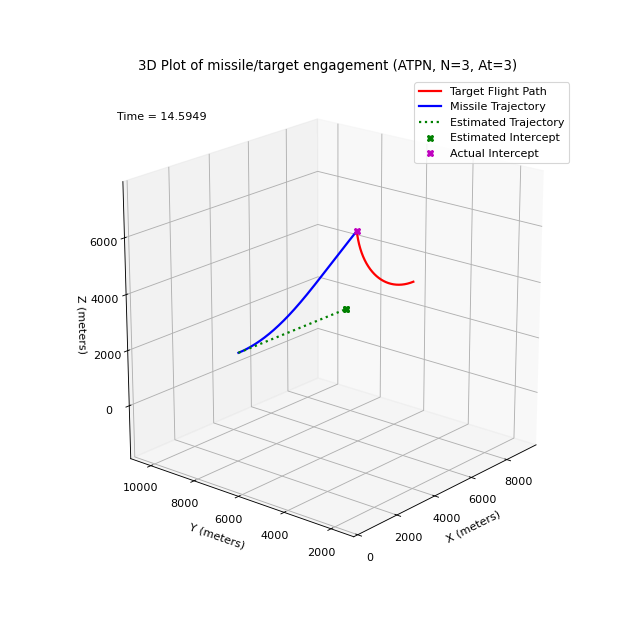

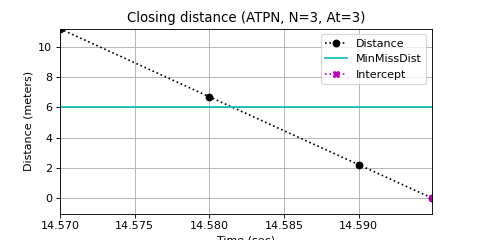

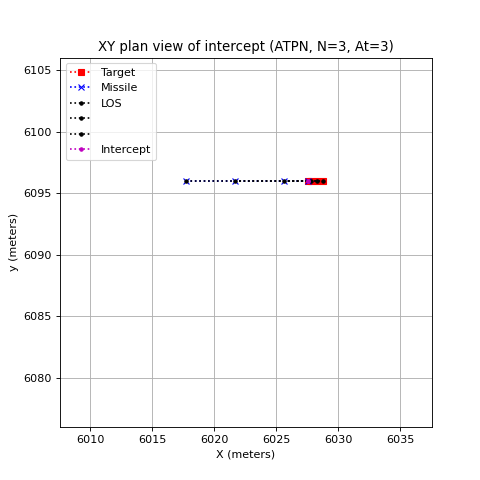

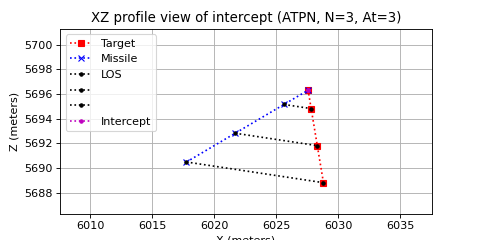

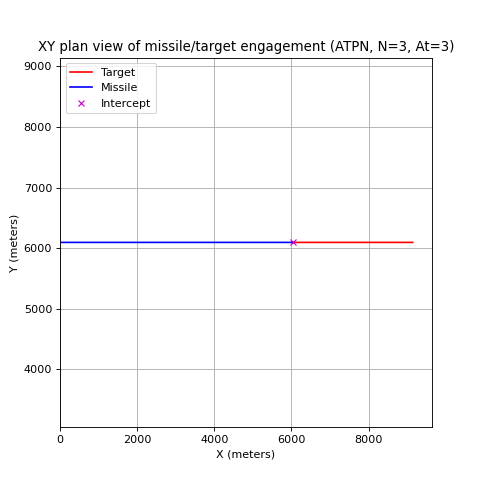

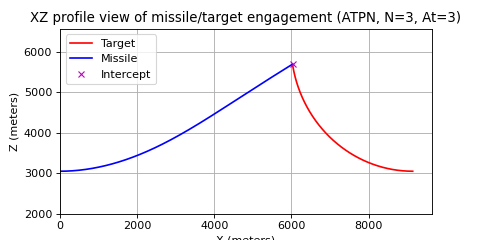

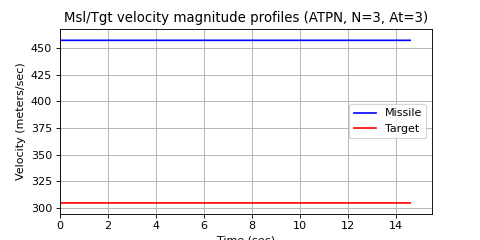

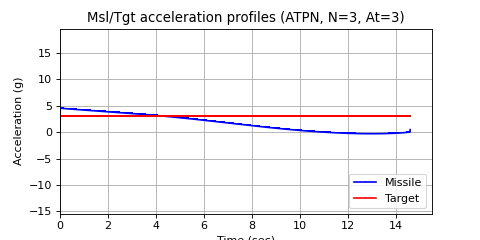

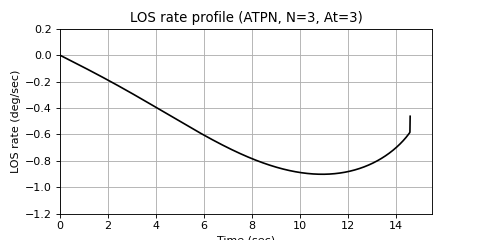

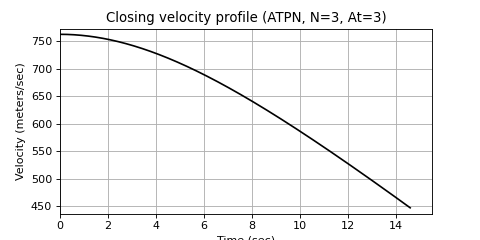

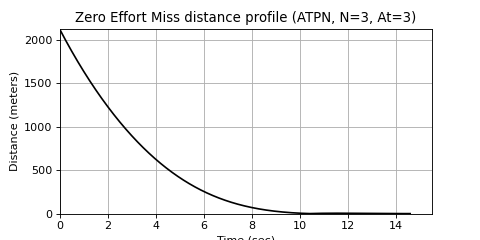

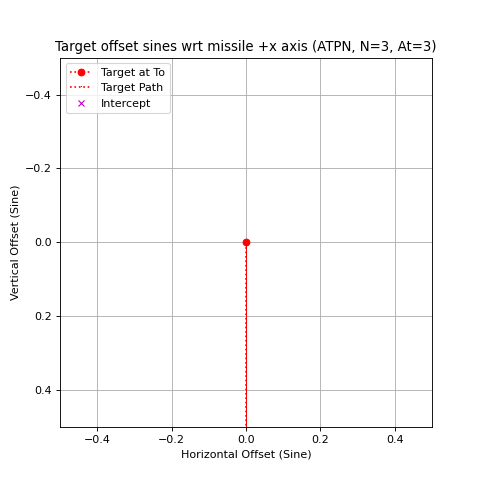

In [10]:
if __name__ == "__main__":
    
    # Globals for saving last predominant missile rotation, Pitch
    # or Yaw, and last LOS rate and missile acceleration signs to
    # explain sign changes in LOS rate and missile acceleration 
    # profile plots.
    
    global LastPorY  # pitch or yaw:  'P' or 'Y'
    global LastWsgn  # LOS rate sign: -1.0 or 1.0
    global LastAsgn  # missile acceleration sign: -1.0 or 1.0
    
    LastPorY = None
    LastWsgn = None
    LastAsgn = None
    
    # Estimate time-to-intercept and target position
    # at intercept using Law of Cosines:
    #
    #   C**2 = A**2 + B**2 - 2*A*B*cos(alpha)
    #
    # where:
    #
    #   A     = |Pt0 - Pm0|
    #   B     = |Vm0|*tint
    #   C     = |Vt0|*tint
    #   alpha = leadAngle
    #
    # Then solve the quadratic equation for tint.
    
    magVt = la.norm(Vt0)
    dtm   = la.norm(Prel(Pt0,Pm0))
    alpha = leadAngle(Pt0, Vt0, Pm0, magVm)
    
    c2 = magVm**2 - magVt**2
    c1 = -2*magVm*dtm*cos(alpha)
    c0 = dtm**2
    p  = np.poly1d([c2,c1,c0])
    
    tint  = np.amin(np.abs(p.roots))
    EstPt = Pt0 + Vt0*tint
    
    if tint > tStop:
        print("Error:  estimated time-to-intercept=%8.4f > T_STOP=%8.4f" %
              (tint, tStop))
        sys.exit()
    
    # Calculate azimuth and elevation of estimated target position
    # with respect to missile initial position at time of intercept.
    
    if maz is None:
        maz = atan((EstPt[1]-Pm0[1])/la.norm([EstPt[0]-Pm0[0]]))*DPR
    if mel is None:
        mel = atan((EstPt[2]-Pm0[2])/la.norm([EstPt[0]-Pm0[0], EstPt[1]-Pm0[1]]))*DPR

    Vm0 = setVm(magVm, maz*RPD, mel*RPD)
   
    print("Applying %s proportional navigation guidance law." % (PN_LAWS[PNAV]))
    
    if PRINT_DATA:
        print("Target initial position:  [%9.2f, %9.2f, %9.2f]" % 
              (Pt0[0], Pt0[1], Pt0[2]))
        print("Target initial velocity:  [%9.3f, %9.3f, %9.3f]" % 
              (Vt0[0], Vt0[1], Vt0[2]))
        print("Missile initial position: [%9.2f, %9.2f, %9.2f]" % 
              (Pm0[0], Pm0[1], Pm0[2]))
        print("Target velocity magnitude:    %9.3f" % magVt)
        print("Missile velocity magnitude:   %9.3f" % magVm)
        print("Estimated time-to-intercept:  %9.5f" % tint)
        print("Estimated target position:  [%9.2f, %9.2f, %9.2f]" % 
              (EstPt[0], EstPt[1], EstPt[2]))
        print("Missile (az, el) lead angles:  (%8.3f, %8.3f) degrees" % 
              (maz, mel))
        print("Missile initial velocity:   [%9.3f, %9.3f, %9.3f]" % 
              (Vm0[0], Vm0[1], Vm0[2]))
    
    # Initialize 3D plot for engagement animation.
    
    Writer = None
    if SAVE_ANIM:
        try:
            Writer = animation.writers['ffmpeg']
        except KeyError:
            try:
                Writer = animation.writers['avconv']
            except KeyError:
                print("Cannot save animation, no animation writers available!")
                print("Try installing ffmpeg or avconv.")
                SAVE_ANIM = False
    
    if SHOW_ANIM or SAVE_ANIM:
        fig3D = plt.figure(13, figsize=(6,6), dpi=100)
        ax3D  = fig3D.add_subplot(111, projection='3d',
                                  autoscale_on=False, animated=False)
        # Instantiate artist for each line/point to be drawn on 3D plot.
        linePt = Line3D([], [], [], color='r', ls=' ', lw=1.0,
                        marker='s', mew=1.0, mec='r', mfc='w',
                        label='Target', animated=False)  # target in 3D space
        linePm = Line3D([], [], [], color='b', ls=' ', lw=1.0,
                        marker='x', mew=0.5, mec='b', mfc='w',
                        label='Missile', animated=False)  # missile in 3D space
        linePx = Line3D([], [], [], color='k', ls=' ', lw=1.0,
                        marker=' ', mew=1.0, mec='k', mfc='k',
                        label='', animated=False)  # intercept in 3D space
        linePtv = Line3D([], [], [], color='r', ls='-', lw=1.0,
                         marker=' ', mew=0.5, mec='r', mfc='r',
                         label='', animated=False)  # tgt vel in 3D space
        linePmv = Line3D([], [], [], color='b', ls='-', lw=1.0,
                         marker=' ', mew=0.5, mec='b', mfc='b',
                         label='', animated=False)  # msl vel in 3D space
        linePma = Line3D([], [], [], color='m', ls='-', lw=1.0,
                         marker=' ', mew=0.5, mec='m', mfc='m',
                         label='Command Accel', animated=False)  # msl acc in 3D space
        linePwr = Line3D([], [], [], color='g', ls='-', lw=1.0,
                         marker=' ', mew=0.5, mec='g', mfc='g',
                         label='Rlos Ang Vel', animated=False)  # Rlos ang vel in 3D space
        linePttrk = Line3D([], [], [], color='r', ls='-', lw=1.0,
                           marker=' ', mew=0.5, mec='r', mfc=None,
                           label='', animated=False)  # target track in 3D space
        linePtxy = Line3D([], [], [], color='r', ls=':', lw=0.5,
                           marker=' ', mew=0.5, mec='r', mfc=None,
                           label='', animated=False)  # target track in XY plane
        linePtxz = Line3D([], [], [], color='r', ls=':', lw=0.5,
                           marker=' ', mew=0.5, mec='r', mfc=None,
                           label='', animated=False)  # target track in XZ plane
        linePmtrk = Line3D([], [], [], color='b', ls='-', lw=1.0,
                           marker=' ', mew=0.5, mec='b', mfc=None,
                           label='', animated=False)  # missile track in 3D space
        linePmxy = Line3D([], [], [], color='b', ls=':', lw=0.5,
                           marker=' ', mew=0.5, mec='b', mfc=None,
                           label='', animated=False)  # missile track in XY plane
        linePmxz = Line3D([], [], [], color='b', ls=':', lw=0.5,
                           marker=' ', mew=0.5, mec='b', mfc=None,
                           label='', animated=False)  # missile track in XZ plane
        linePttgoxy = Line3D([], [], [], color='k', ls=':', lw=1.0,
                              marker='s', mew=0.5, mec='r', mfc='w',
                              label='', animated=False)  # Estimated tgt Tgo loc in XY plane
        linePttgoxz = Line3D([], [], [], color='k', ls=':', lw=1.0,
                              marker='s', mew=0.5, mec='r', mfc='w',
                              label='', animated=False)  # Estimated tgt Tgo loc in XZ plane
        linePmtgoxy = Line3D([], [], [], color='k', ls=':', lw=1.0,
                              marker='x', mew=0.5, mec='b', mfc=None,
                              label='', animated=False)  # Estimated msl Tgo loc in XY plane
        linePmtgoxz = Line3D([], [], [], color='k', ls=':', lw=1.0,
                              marker='x', mew=0.5, mec='b', mfc=None,
                              label='', animated=False)  # Estimated msl Tgo loc in XZ plane
        # Set 3D plot title and axes labels.
        text = "3D Animation of missile/target engagement ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
        ax3D.set_title(text)
        ax3D.set_xlabel('X (meters)')
        ax3D.set_ylabel('Y (meters)')
        ax3D.set_zlabel('Z (meters)')
        # Set/get 3D plot axes data limits; enable drawing grid lines.
        if MSL == SAM:
            ax3D.set_xlim3d([Pm0[0],  Pt0[0]+500.0])
            ax3D.set_ylim3d([Pm0[1],  Pm0[1]+(Pt0[0]+500-Pm0[0])])
            ax3D.set_zlim3d([0.0,    (Pt0[0]+500-Pm0[0])/2])
        else:
            ax3D.set_xlim3d([floor(Pm0[0]/500.0)*500.0,
                             ceil(Pt0[0]/500.0)*500.0])
            ax3D.set_ylim3d([floor(Pm0[1]/500.0)*500.0 - 
                             (ceil(Pt0[0]/500.0)*500.0 - 
                              floor(Pm0[0]/500.0)*500.0)/2,
                             floor(Pm0[1]/500.0)*500.0 +
                             (ceil(Pt0[0]/500.0)*500.0 - 
                              floor(Pm0[0]/500.0)*500.0)/2])
            ax3D.set_zlim3d([floor(Pm0[2]/500.0)*500.0 - 
                             (ceil(Pt0[0]/500.0)*500.0 - 
                              floor(Pm0[0]/500.0)*500.0)/2,
                             floor(Pm0[2]/500.0)*500.0 +
                             (ceil(Pt0[0]/500.0)*500.0 - 
                              floor(Pm0[0]/500.0)*500.0)/2])
            ax3D.set_aspect('equal')
        (xmin, xmax) = ax3D.get_xlim()
        (ymin, ymax) = ax3D.get_ylim()
        (zmin, zmax) = ax3D.get_zlim()
        ax3D.grid()
        # Set scale factor for drawing "quiver" vectors (i.e., Vt, Vm, Am, Wr).
        Qsfac = abs(xmax-xmin)/15.0
        # Instantiate artist for frame time to be drawn on 3D plot.
        time_text = ax3D.text3D(xmin-500.0, ymax+100.0, zmax+(zmax-zmin)/4.0, '')
        # Add line artists to 3D plot and set legend location.
        ax3D.add_line(linePt)
        ax3D.add_line(linePm)
        ax3D.add_line(linePma)
        ax3D.add_line(linePwr)
        ax3D.add_line(linePx)
        ax3D.add_line(linePtv)
        ax3D.add_line(linePmv)
        ax3D.add_line(linePttrk)
        ax3D.add_line(linePtxy)
        ax3D.add_line(linePtxz)
        ax3D.add_line(linePmtrk)
        ax3D.add_line(linePmxy)
        ax3D.add_line(linePmxz)
        ax3D.add_line(linePttgoxy)
        ax3D.add_line(linePttgoxz)
        ax3D.add_line(linePmtgoxy)
        ax3D.add_line(linePmtgoxz)
        ax3D.legend(loc='upper right')
        # Set 3D plot viewing orientation, then draw everything.
        ax3D.view_init(elev=20.0, azim=220.0)
        fig3D.canvas.draw()
        if SHOW_ANIM:
            # Note: The mouse is disabled to prevent the user from
            #       changing 3D projection perspective and scaling
            #       by 3D rotation, panning or zooming. However, it
            #       would be advantageous for the user not to be so
            #       restricted.
            ax3D.disable_mouse_rotation()
            bckgrnd = fig3D.canvas.copy_from_bbox(fig3D.bbox)
            backend = mpl.get_backend().upper()
            plt.show(block=False)
     
    # Initialize state vector.
    
    S = setS(S, Vt0, Pt0, Vm0, Pm0, pitchAngle(Vt0))
    
    # Instantiate Runge-Kutta 4th order ode solver, initialize
    # using current state with state time set to zero.
    
    rk4 = RK4_Solver(tStep, nSvar)
    
    S[0] = 0.0
    rk4.init(S)
    
    ## Loop until termination event or simulation stop condition reached.
    
    t     = S[0]
    i     = 0
    istop = None  # used within onPress and anim3D procedures
        
    while (not Stop(S)) and (i < nSamples):
        
        if i == 0 or PRINT_DATA or SHOW_ANIM or SAVE_ANIM or PLOT_DATA or PRINT_TXYZ:            
            collectData(i, t, S)
            
        if SHOW_ANIM:
            fig3D.canvas.restore_region(bckgrnd)
            for a in (anim3D(i)):
                ax3D.draw_artist(a)
            blit3D(fig3D, ax3D, backend)
            
        # Perform RK4 integration for animation frame.
        for n in range(0, N_STEP):
            if not Stop(S):
                S = rk4.step(S, dotS)
        
        # Update simulation time and data samples index.
        t = S[0]
        i = i + 1
        
    ## Exited simulation loop.
    
    # Using states and derivatives prior to
    # stop time, reduce step size and integrate
    # till final stop condition.
    
    num_trys = 0  # account for non-covergent intercepts
    max_trys = 4
    
    while (tStep > DT_FINAL) and (num_trys < max_trys):
        
        print("\nt=%9.5f  tStep=%9.5f  num_trys=%d  Dclose=%f" % 
              (S[0], tStep, num_trys, Dclose(S)))
        
        S = rk4.get_Sprev()
        
        last_tStep = tStep
        tStep      = delT(S)
         
        rk4 = RK4_Solver(tStep, nSvar)
    
        rk4.init(S)
        
        while (not Stop(S)):
            S = rk4.step(S, dotS)
            
        if tStep == last_tStep:
            num_trys = num_trys + 1
    
    S = rk4.get_Sprev()
    t = S[0]
    
    if num_trys == max_trys:       
        if t < tStop-tStep:
            print("\n*** Non-convergent Intercept ***")
        else:
            print("\n*** Insufficient Simulation Time ***")   
        INTERCEPT = False
    else:
        INTERCEPT = True
        
    # Display last missile and target states and
    # intercept status; collect data for plotting
    # or printing.
    
    PRINT_DATA = True
    
    collectData(i, t, S)
    
    istop = i
    iend  = istop + 1
    
    if (num_trys == max_trys) or (Dclose(S) > MinMissDist):
        INTERCEPT = False
        print("\n*** Missile missed target.")
    else:
        INTERCEPT = True
        print("\n*** Missile intercepted target.")
        
    if SHOW_ANIM or SAVE_ANIM or PLOT_DATA or PRINT_TXYZ:
        
        # Ensure Time data array contains nSamples of simulation time steps
        # in order to prevent plotted lines from wrapping back to time 0.0
        # if the simulation loop was terminated before all nSamples of data
        # were collected. Note: This may no longer be necessary.
        
        while i < nSamples:
            Time[i] = t
            t = t + N_TIME
            i = i + 1
            
    if SHOW_ANIM:
        
        # Display location of actual or missed intercept, then
        # enter interactive replay loop.
        
        fig3D.canvas.restore_region(bckgrnd)
        for a in (anim3D(istop)):
            ax3D.draw_artist(a)
        blit3D(fig3D, ax3D, backend)
        fig3D.canvas.draw()

        nincr    = 0
        paused   = True
        quitflag = False
        doneflag = False
        
        # Connect Figure 13 key press handler.
        cidkey = fig3D.canvas.mpl_connect('key_press_event', onPress)
        
        print("\nThe 3D engagement animation may be replayed forward and backward")
        print("in time. To reset the animation, press Space bar to unpause, then")
        print("press Up Arrow key to play forward in time. If the animation is")
        print("exited, press Up Arrow key to restart forward in time, or press")
        print("Esc key to exit Figure 13 and continue on with program processing.")
        print("During animation the following key presses are recognized:\n")

        print("Press Up Arrow key twice to play animation forward in time.")
        print("Press Down Arrow key twice to play animation backward in time.")
        print("Press Right Arrow key to step animation one frame forward in time.")
        print("Press Left Arrow key to step animation one frame backward in time.")
        print("Press Space bar to toggle pause/unpause.")
        print("Press X key to exit animation (press Up Arrow key start replay).")
        print("Press Esc key to exit Figure 13.")
        
        # Interactive replay loop.
        while not doneflag:
            if paused:
                fig3D.canvas.flush_events()
                continue
            quitflag = False
            nincr    = 0
            iloop    = 0
            init3D()
            while not quitflag:
                if doneflag or (iloop > istop) or (iloop < 0):
                    quitflag = True
                    break
                if quitflag:
                    break
                if paused:
                    fig3D.canvas.flush_events()
                    continue
                fig3D.canvas.restore_region(bckgrnd)
                for a in (anim3D(iloop)):
                    ax3D.draw_artist(a)
                blit3D(fig3D, ax3D, backend)
                iloop += nincr
                iloop = min(max(0,iloop),istop)
                
        # Disconnect Figure 13 key press handler.
        fig3D.canvas.mpl_disconnect(cidkey)
        
        # Enable 3D rotation, panning and zooming of final Figure
        # 13 image displayed.
        ax3D.mouse_init()
        
        if not (PLOT_DATA or SAVE_ANIM):
            if PRINT_TXYZ:
                print("\nClose Figure 13 to continue program.")
            else:
                print("\nClose Figure 13 to terminate program.")
            plt.show(block=True)
    
    if SAVE_ANIM:
        
        # Create and show the 3D engagement animation.
        
        nframes   = iend
        tdel      = 1.0/FPS
        tdel_msec = 1000.0*tdel
        try:
            tmsec0 = 1000.0*time.clock()
        except:
            tmsec0 = 1000.0*time.process_time()
        anim3D(0)
        try:
            tmsec1 = 1000.0*time.clock()
        except:
            tmsec1 = 1000.0*time.process_time()
        tstep = tmsec1 - tmsec0
        #interval  = max(ceil(tmsec1-tmsec0),1.0) # allows faster than real-time
        interval  = tdel_msec - tstep   # approximates real-time
        anim = animation.FuncAnimation(fig3D, anim3D, init_func=init3D,
                                       frames=nframes, blit=True,
                                       cache_frame_data=True,
                                       interval=interval, repeat=False)
        print("\nCreating animation video; presentation will begin shortly...")
        writer = Writer(fps=FPS, codec='h264',
                        metadata=dict(artist='propNav'),
                        bitrate=-1)
        sbuff = StringIO()
        sbuff.write("%1d%1d%1d%1d" % (int(MSL), int(PNAV), int(Nm), int(Nt)))
        case = sbuff.getvalue()
        sbuff.close()
        filename = './img/propNav_' + case + '.mp4'
        anim.save(filename, writer=writer)
        print("Animation saved in file %s" % filename)
        if PLOT_DATA or PRINT_TXYZ:
            print("\nAfter animation stops, close Figure 13 to continue program.")
        else:
            print("\nAfter animation stops, close Figure 13 to terminate program.")
        plt.show()
    
    if PLOT_DATA:
        
        # Create and show the plot figures.
        plt.close('all')
        figures = []
        print("\n")
        
        if PLOT_FIGS[1]:
            ## Figure 1 - Closing distance at tStop.
            figures.append(plt.figure(1, figsize=(6,3), dpi=80))
            text = "Closing distance ({0}, N={1}, At={2})"\
                 .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('Distance (meters)')
            plt.xlim([Time[istop-3], Time[istop]])
            plt.ylim([-1.0, Dcls[istop-3]])
            plt.grid()
            plt.plot(Time[istop-3:iend], Dcls[istop-3:iend], 'o:k')
            plt.plot(np.array([Time[istop-3], Time[istop]]), 
                     np.array([MinMissDist, MinMissDist]), '-c')
            if INTERCEPT:
                plt.plot(Time[istop], Dcls[istop], 'X:m')
                plt.legend(['Distance','MinMissDist','Intercept'])
            else:
                plt.plot(Time[istop], Dcls[istop], 'o:c')
                plt.legend(['Distance','MinMissDist','Missed'])
        
        if PLOT_FIGS[2]:
            ## Figure 2 - XY plan view of intercept geometry at tStop.
            figures.append(plt.figure(2, figsize=(6,6), dpi=80))
            text = "XY plan view of intercept ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('X (meters)')
            plt.ylabel('y (meters)')
            if MSL == SAM:
                plt.xlim([(Pmx[istop]+Ptx[istop])/2-max(10.0, Dcls[istop]),
                          (Pmx[istop]+Ptx[istop])/2+max(10.0, Dcls[istop])/2.0])
                plt.ylim([(Pmy[istop]+Pty[istop])/2-max(10.0, Dcls[istop]),
                          (Pmy[istop]+Pty[istop])/2+max(10.0, Dcls[istop])/2.0])
            else:
                plt.xlim([(Pmx[istop]+Ptx[istop])/2-max(20.0, Dcls[istop]),
                          (Pmx[istop]+Ptx[istop])/2+max(20.0, Dcls[istop])/2.0])
                plt.ylim([(Pmy[istop]+Pty[istop])/2-max(20.0, Dcls[istop]),
                          (Pmy[istop]+Pty[istop])/2+max(20.0, Dcls[istop])/2.0])
            plt.grid()
            plt.plot(Ptx[istop-3:iend], Pty[istop-3:iend], 's:r',
                     Pmx[istop-3:iend], Pmy[istop-3:iend], 'x:b',
                     np.array([Pmx[istop-3],Ptx[istop-3]]),
                     np.array([Pmy[istop-3],Pty[istop-3]]), '.:k',
                     np.array([Pmx[istop-2],Ptx[istop-2]]),
                     np.array([Pmy[istop-2],Pty[istop-2]]), '.:k',
                     np.array([Pmx[istop-1],Ptx[istop-1]]),
                     np.array([Pmy[istop-1],Pty[istop-1]]), '.:k')
            if INTERCEPT:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmy[istop],Pty[istop]]), '.:m')
                plt.legend(('Target','Missile','LOS',' ',' ','Intercept'), loc='upper left')
            else:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmy[istop],Pty[istop]]), '.:c')
                plt.legend(('Target','Missile','LOS',' ', ' ','Missed'), loc='upper left')
        
        if PLOT_FIGS[3]:
            ## Figure 3 - XZ profile view of intercept geometry at tStop.
            figures.append(plt.figure(3, figsize=(6,3), dpi=80))
            text = "XZ profile view of intercept ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('X (meters)')
            plt.ylabel('Z (meters)')
            if MSL == SAM:
                plt.xlim([(Pmx[istop]+Ptx[istop])/2-max(10.0, Dcls[istop]),
                          (Pmx[istop]+Ptx[istop])/2+max(10.0, Dcls[istop])/2.0])
                plt.ylim([(Pmz[istop]+Ptz[istop])/2-max(10.0, Dcls[istop])/2.0,
                          (Pmz[istop]+Ptz[istop])/2+max(10.0, Dcls[istop])/4.0])
            else:
                plt.xlim([(Pmx[istop]+Ptx[istop])/2-max(20.0, Dcls[istop]),
                          (Pmx[istop]+Ptx[istop])/2+max(20.0, Dcls[istop])/2.0])
                plt.ylim([(Pmz[istop]+Ptz[istop])/2-max(20.0, Dcls[istop])/2.0,
                          (Pmz[istop]+Ptz[istop])/2+max(20.0, Dcls[istop])/4.0])
            plt.grid()
            plt.plot(Ptx[istop-3:iend], Ptz[istop-3:iend], 's:r',
                     Pmx[istop-3:iend], Pmz[istop-3:iend], 'x:b',
                     np.array([Pmx[istop-3],Ptx[istop-3]]),
                     np.array([Pmz[istop-3],Ptz[istop-3]]), '.:k',
                     np.array([Pmx[istop-2],Ptx[istop-2]]),
                     np.array([Pmz[istop-2],Ptz[istop-2]]), '.:k',
                     np.array([Pmx[istop-1],Ptx[istop-1]]),
                     np.array([Pmz[istop-1],Ptz[istop-1]]), '.:k')
            if INTERCEPT:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmz[istop],Ptz[istop]]), '.:m')
                plt.legend(('Target','Missile','LOS',' ',' ','Intercept'), loc='upper left')
            else:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmz[istop],Ptz[istop]]), '.:c')
                plt.legend(('Target','Missile','LOS',' ',' ','Missed'), loc='upper left')
        
        if PLOT_FIGS[4]:
            ## Figure 4 - XY plan view of missile/target engagement.
            figures.append(plt.figure(4, figsize=(6,6), dpi=80))
            text = "XY plan view of missile/target engagement ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('X (meters)')
            plt.ylabel('Y (meters)')
            plt.xlim([Pm0[0], Pt0[0]+500.0])
            if MSL == SAM:
                plt.ylim([Pm0[1], Pm0[1]+(Pt0[0]+500-Pm0[0])])
            else:
                plt.ylim([Pm0[1]-Pm0[1]/2.0, Pm0[1]+Pm0[1]/2])
            plt.grid()
            plt.plot(Ptx[0:iend], Pty[0:iend], '-r',
                     Pmx[0:iend], Pmy[0:iend], '-b')
            if INTERCEPT:
                plt.plot(Pmx[istop:iend], Pmy[istop:iend], 'xm')
                plt.legend(('Target','Missile','Intercept'), loc='upper left')
            else:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmy[istop],Pty[istop]]), 'oc')
                plt.legend(('Target','Missile','Missed'), loc='upper left')
        
        if PLOT_FIGS[5]:
            ## Figure 5 - XZ profile view of missile/target engagement.
            figures.append(plt.figure(5, figsize=(6,3), dpi=80))
            text = "XZ profile view of missile/target engagement ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('X (meters)')
            plt.ylabel('Z (meters)')
            plt.xlim([Pm0[0], Pt0[0]+500.0])
            if MSL == SAM:
                plt.ylim([0.0, (Pt0[0]+500-Pm0[0])/2])
            else:
                plt.ylim([floor(min(Pmz[0:istop])/1000.0)*1000.0 - 1000.0,
                          floor(min(Pmz[0:istop])/1000.0)*1000.0 + 
                          (Pt0[0]-Pm0[0])/2 - 1000.0])
            plt.grid()
            plt.plot(Ptx[0:iend], Ptz[0:iend], '-r',
                     Pmx[0:iend], Pmz[0:iend], '-b')
            if INTERCEPT:
                plt.plot(Pmx[istop:iend], Pmz[istop:iend], 'xm')
                plt.legend(('Target','Missile','Intercept'), loc='upper left')
            else:
                plt.plot(np.array([Pmx[istop],Ptx[istop]]),
                         np.array([Pmz[istop],Ptz[istop]]), 'oc')
                plt.legend(('Target','Missile','Missed'), loc='upper left')
        
        if PLOT_FIGS[6]:
            ## Figure 6 - Msl/Tgt velocity magnitude vs time of flight
            ##            up to point just before flight termination.
            ##            Note: This is a constant velocity missile.
            figures.append(plt.figure(6, figsize=(6,3), dpi=80))
            text = "Msl/Tgt velocity magnitude profiles ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('Velocity (meters/sec)')
            plt.xlim([0.0, T_STOP])
            plt.ylim([Velt[0]-10, ceil(max(Velm[0:istop]))+10])
            plt.grid()
            plt.plot(Time[0:istop], Velm[0:istop], '-b')
            plt.plot(Time[0:istop], Velt[0:istop], '-r')
            plt.legend(('Missile','Target'), loc='center right')
       
        if PLOT_FIGS[7]:
            ## Figure 7 - Msl/Tgt acceleration vs time of flight up
            ##            to point just before flight termination.
            figures.append(plt.figure(7, figsize=(6,3), dpi=80))
            text = "Msl/Tgt acceleration profiles ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('Acceleration (g)')
            plt.xlim([0.0, T_STOP])
            plt.ylim([floor((min([min(Acmg[0:istop]),min(Atg[0:istop])])-Gmmax[MSL]/2)*10.0)/10.0,
                      ceil((max([max(Acmg[0:istop]),max(Atg[0:istop])])+Gmmax[MSL]/2)*10.0)/10.0])
            plt.grid()
            plt.plot(Time[0:istop], Acmg[0:istop], ',-b')
            plt.plot(Time[0:istop], Atg[0:istop], ',-r')
            plt.legend(('Missile','Target'), loc='lower right')
        
        if PLOT_FIGS[8]:
            ## Figure 8 - Line-of-Sight rate vs time of flight up
            ##            to point just before flight termination.
            figures.append(plt.figure(8, figsize=(6,3), dpi=80))
            text = "LOS rate profile ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('LOS rate (deg/sec)')
            plt.xlim([0.0, T_STOP])
            plt.ylim([max([floor(min(LOSd[0:istop]))-0.2,-6]), 
                      min([ ceil(max(LOSd[0:istop]))+0.2, 6])])
            plt.grid()
            plt.plot(Time[0:istop], LOSd[0:istop], '-k')
        
        if PLOT_FIGS[9]:
            ## Figure 9 - Closing velocity vs time of flight up
            ##            to point just before flight termination.
            figures.append(plt.figure(9, figsize=(6,3), dpi=80))
            text = "Closing velocity profile ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('Velocity (meters/sec)')
            plt.xlim([0.0, T_STOP])
            plt.ylim([floor(min(VELc[0:istop]))-10.0,
                      ceil(max(VELc[0:istop]))+10.0])
            plt.grid()
            plt.plot(Time[0:istop], VELc[0:istop], '-k')
        
        if PLOT_FIGS[10]:
            ## Figure 10 - Zero Effort Miss distance vs time of flight
            ##             up to point just before flight termination.
            figures.append(plt.figure(10, figsize=(6,3), dpi=80))
            text = "Zero Effort Miss distance profile ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Time (sec)')
            plt.ylabel('Distance (meters)')
            plt.xlim([0.0, T_STOP])
            plt.ylim([0.0, ceil(max(ZEMd[0:istop]))+10.0])
            plt.grid()
            plt.plot(Time[0:istop], ZEMd[0:istop], '-k')
        
        if PLOT_FIGS[11]:
            ## Figure 11 - Target offset sines wrt missile +x axis.
            figures.append(plt.figure(11, figsize=(6,6), dpi=80))
            text = "Target offset sines wrt missile +x axis ({0}, N={1}, At={2})"\
                .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            plt.title(text)
            plt.xlabel('Horizontal Offset (Sine)')
            plt.ylabel('Vertical Offset (Sine)')
            plt.xlim([-0.5,  0.5])  # +/- 30 degrees
            plt.ylim([ 0.5, -0.5])  # +/- 30 degrees
            plt.grid()
            plt.plot(Thoff[0:1], Tvoff[0:1], 'o:r')
            plt.plot(Thoff[1:iend], Tvoff[1:iend], ',:r')
            if INTERCEPT:
                plt.plot(Thoff[istop:iend], Tvoff[istop:iend], 'xm')
                plt.legend(('Target at To','Target Path','Intercept'), loc='upper left')
            else:
                plt.plot(Thoff[istop:iend], Tvoff[istop:iend], 'oc')
                plt.legend(('Target at To','Target Path','Missed'), loc='upper left')
        
        if PLOT_FIGS[12]:
            ## Figure 12 - 3D missile/target engagement trajectories plot.
            figures.append(plt.figure(12, figsize=(8,8), dpi=80))
            ax = figures[-1].add_subplot(projection='3d')
            text = "3D Plot of missile/target engagement ({0}, N={1}, At={2})"\
               .format(PN_LAWS[PNAV], int(Nm), int(Nt))
            ax.set_title(text)
            ax.set_xlabel('X (meters)')
            ax.set_ylabel('Y (meters)')
            ax.set_zlabel('Z (meters)')
            if MSL == SAM:
                ax.set_xlim3d([Pm0[0],  Pt0[0]+500.0])
                ax.set_ylim3d([Pm0[1],  Pm0[1]+(Pt0[0]+500-Pm0[0])])
                ax.set_zlim3d([0.0,    (Pt0[0]+500-Pm0[0])/2])
            else:
                ax.set_xlim3d([floor(Pmx[0]/500.0)*500.0,
                               ceil(Ptx[0]/500.0)*500.0])
                ax.set_ylim3d([floor(Pmy[0]/500.0)*500.0 - 
                               (ceil(Ptx[0]/500.0)*500.0 - 
                               floor(Pmx[0]/500.0)*500.0)/2,
                               floor(Pmy[0]/500.0)*500.0 +
                               (ceil(Ptx[0]/500.0)*500.0 - 
                               floor(Pmx[0]/500.0)*500.0)/2])
                ax.set_zlim3d([floor(Pmz[0]/500.0)*500.0 - 
                               (ceil(Ptx[0]/500.0)*500.0 - 
                                floor(Pmx[0]/500.0)*500.0)/2,
                               floor(Pmz[0]/500.0)*500.0 +
                               (ceil(Ptx[0]/500.0)*500.0 - 
                                floor(Pmx[0]/500.0)*500.0)/2])
                ax.set_aspect('equal')
            ax.grid()
            # target in 3D space
            line1 = Line3D(Ptx[0:iend], Pty[0:iend], Ptz[0:iend],
                           color='r', ls='-', lw=2.0,       
                           marker=' ', mew=2.0, mec='r', mfc='r',
                           label='Target Flight Path')
            # missile in 3D space
            line2 = Line3D(Pmx[0:iend], Pmy[0:iend], Pmz[0:iend],
                           color='b', ls='-', lw=2.0,       
                           marker=' ', mew=2.0, mec='b', mfc='b',
                           label='Missile Trajectory')
            # estimated intercept trajectory in 3D space
            line3 = Line3D(np.array([Pm0[0],EstPt[0]]),
                           np.array([Pm0[1],EstPt[1]]),
                           np.array([Pm0[2],EstPt[2]]),
                           color='g', ls=':', lw=2.0,       
                           marker=' ', mew=1.0, mec='g', mfc='g',
                           label='Estimated Trajectory')
            # estimated intercept point in 3D space
            line4 = Line3D(np.array([EstPt[0],EstPt[0]]),
                           np.array([EstPt[1],EstPt[1]]),
                           np.array([EstPt[2],EstPt[2]]),
                           color='g', ls=' ', lw=1.0,       
                           marker='X', mew=1.0, mec='g', mfc='g',
                           label='Estimated Intercept')
            if INTERCEPT:    
                # intercept point in 3D space
                line5 = Line3D(Pmx[istop:iend], Pmy[istop:iend], Pmz[istop:iend],
                               color='m', ls=' ', lw=1.0,       
                               marker='X', mew=1.0, mec='m', mfc='m',
                               label='Actual Intercept')
            else:
                # missed target and missile points in 3D space
                line5 = Line3D(np.array([Pmx[istop],Ptx[istop]]),
                               np.array([Pmy[istop],Pty[istop]]),
                               np.array([Pmz[istop],Ptz[istop]]),
                               color='c', ls=' ', lw=1.0,       
                               marker='o', mew=1.0, mec='c', mfc='c',
                               label='Missed Intercept')
            ax.add_line(line1)
            ax.add_line(line2)
            ax.add_line(line3)
            ax.add_line(line4)
            ax.add_line(line5)
            
            (xmin, xmax) = ax.get_xlim()
            (ymin, ymax) = ax.get_ylim()
            (zmin, zmax) = ax.get_zlim()
            time_text = ax.text3D(xmin-500.0, ymax+100.0, zmax+(zmax-zmin)/4.0,
                                  'Time = %.4f' % Time[istop])    
            
            ax.legend(loc='upper right')
            ax.view_init(elev=20.0, azim=220.0)
        
        def move_fig(fig):
            """
            Moves given figure plot window based on figure's number.
            """
            fign = fig.number
            x, y = 60*(fign+1), 40*(fign+1)
            backend = mpl.get_backend().upper()
            if backend[0:2] == 'WX':
                fig.canvas.manager.window.SetPosition((x,y))
            elif backend[0:2] == 'TK':
                fig.canvas.manager.window.wm_geometry("+%d+%d" % (x,y)) 
            else:  # QT or GTK
                fig.canvas.manager.window.move(x,y)
        
        try:
            for fig in figures:
                move_fig(fig)
            # Block to keep plots displayed when not running interactively.
            plt.show(block=True)
            plt.close('all')
        except AttributeError:
            # Possibly running "inline".
            plt.show()
    
    if PRINT_TXYZ:
            
        # Set constant missile spin rate. This is purely a 
        # cosmetic effect to provide rendering realism for
        # spin stabilized missiles. Spin is not considered
        # in kinematic equations of motion.

        twopi = 2.0*pi
        fspin = 16.0
        pspin = 1.0/fspin
        wspin = fspin*twopi
        
        # Extract arrays of target and missile position, velocity
        # and acceleration vectors from arrays of saved data. 

        Pte = np.array([[Ptx[0:iend]],
                        [Pty[0:iend]],
                        [Ptz[0:iend]]]).reshape([1,3,iend])
        Vte = np.array([[Vtx[0:iend]],
                        [Vty[0:iend]],
                        [Vtz[0:iend]]]).reshape([1,3,iend])
        Ate = np.array([[Atx[0:iend]],
                        [Aty[0:iend]],
                        [Atz[0:iend]]]).reshape([1,3,iend])
        Pme = np.array([[Pmx[0:iend]],
                        [Pmy[0:iend]],
                        [Pmz[0:iend]]]).reshape([1,3,iend])
        Vme = np.array([[Vmx[0:iend]],
                        [Vmy[0:iend]],
                        [Vmz[0:iend]]]).reshape([1,3,iend])
        Ame = np.array([[Amx[0:iend]],
                        [Amy[0:iend]],
                        [Amz[0:iend]]]).reshape([1,3,iend]) 
    
        #  Calculate missile and target yaw (PSI), pitch (THT) and
        #  roll (PHI) angles.
        #
        #  Note: Vectorized atan2 expression from pitchAngle()
        #        routine used for calculating THTm and THTt.
        #        These equations do not account for instances
        #        where the missile or target have pitched past
        #        +/- 90 degrees.
        
        UVm   = Uvec(Vme[:,0:iend])
        PSImd = np.arctan2(-UVm[0,1,0:iend], UVm[0,0,0:iend],)*DPR
        THTmd = np.arctan2(UVm[0,2,0:iend], 
                           la.norm([UVm[0,0,0:iend], 
                                    UVm[0,1,0:iend]], axis=0))*DPR
        PHIm  = wspin*Time[0:iend]
        PHImd = np.fmod(PHIm[0:iend], twopi)*DPR
        
        UVt   = Uvec(Vte[:,0:iend])
        PSItd = np.arctan2(-UVt[0,1,0:iend], UVt[0,0,0:iend])*DPR       
        """
        THTtd  = np.arctan2(UVt[0,2,0:iend],
                            la.norm([UVt[0,0,0:iend], 
                                     UVt[0,1,0:iend]], axis=0))*DPR
        """
        for i in range(0, iend):
            if ( abs(THTtd[i]) > 90.0):
                # Account for looping maneuver.
                PSItd[i] = np.fmod(PSItd[i] + 180.0, 360.0)
                
        PHIt = np.zeros([iend])
        for i in range(0, iend):
            PHIt[i] = bankAngle(Ate[0,:,i],Vte[0,:,i])
        PHItd = np.fmod(PHIt[0:iend], twopi)*DPR
        
        # Assemble run case identifier appended to "./out/TXYZ.OUT."

        sbuff = StringIO()
        sbuff.write("%1d%1d%1d%1d" % (int(MSL), int(PNAV), int(Nm), int(Nt)))
        case = sbuff.getvalue()
        sbuff.close()
        
        # TXYZ output file record formats.

        fmt1 = " %9.4f %9d %10.2f %10.2f %10.2f %10.2f %10.2f %10.2f"
        fmt2 = " %9d %9d %10.3f %10.3f %10.3f %10.3f %10.3f %10.3f"
        
        # Open TXYZ output file and write trajectory data.
        
        txyz_path = "./out/TXYZ.OUT.{0}".format(case)
        
        try:
            
            f = open(txyz_path, "w")

            for i in range(0, iend):
                print(fmt1 % \
                      (Time[i], 0, Pme[0,0,i], -Pme[0,1,i], -Pme[0,2,i], 
                                   Pte[0,0,i], -Pte[0,1,i], -Pte[0,2,i]),
                      file=f)
                print(fmt2 % \
                      (-9999, -9999, PHImd[i], THTmd[i], PSImd[i], 
                                     PHItd[i], THTtd[i], PSItd[i]),
                      file=f)
        
            # Append padded time record for rendering and display of
            # last frame by threeD program. Time of istop frame plus 
            # 2*F_TIME, but with missile and target states of istop 
            # frame.
        
            print(fmt1 % \
                  (Time[istop]+2*F_TIME, -1, Pme[0,0,istop], -Pme[0,1,istop], -Pme[0,2,istop], 
                                             Pte[0,0,istop], -Pte[0,1,istop], -Pte[0,2,istop]),
                  file=f)
            print(fmt2 % \
                  (-9999, -9999, PHImd[istop], THTmd[istop], PSImd[istop], 
                                 PHItd[istop], THTtd[istop], PSItd[istop]),
                  file=f)
            
            print("\nTXYZ.OUT trajectory data written to:  %s" % txyz_path)
                  
            f.close()
            
        except: 
        
            print("\nError:  TXYZ.OUT trajectory data could not be written.")
